## Setup

In [1]:
SAVE_FIGS = False

if not SAVE_FIGS:
  ![ -d cnn_txf_bias ] || git clone https://github.com/shikhartuli/cnn_txf_bias.git
  %cd cnn_txf_bias
else:
  from google.colab import drive
  drive.mount('/gdrive')
  root = '/gdrive/My Drive/Fall 20-21/COS 454/Project/cnn_txf_bias'
  import os
  if not os.path.isdir(root):
    os.mkdir(root)
  os.chdir(root)
  print(f'\nChanged CWD to "{root}"')

Cloning into 'cnn_txf_bias'...
remote: Enumerating objects: 177, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 3290 (delta 78), reused 135 (delta 47), pack-reused 3113
Receiving objects: 100% (3290/3290), 181.94 MiB | 64.20 MiB/s, done.
Resolving deltas: 100% (758/758), done.
Checking out files: 100% (6027/6027), done.
/content/cnn_txf_bias


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import jensenshannon
import itertools
import os

PLOT_IMAGENET_ACC = True

acc_im = {}
if PLOT_IMAGENET_ACC:
  acc_im['ViT-B_32'] = eval(pd.read_csv(f'./vision_transformer/results/fine-tune/imagenet2012/vit_fine-tune.csv')['ImageNet Accuracy'][0][:-1])/100
  acc_im['ViT-B_32_ft'] = eval(pd.read_csv(f'vision_transformer/results/fine-tune/imagenet2012/vit_fine-tune.csv')['ImageNet Accuracy'][6][:-1])/100
  acc_im['ResNet-50'] = eval(pd.read_csv(f'big_transfer/results/fine-tune/imagenet2012/bit_fine-tune.csv')['ImageNet Accuracy'][0][:-1])/100
  acc_im['ResNet-50_ft'] = eval(pd.read_csv(f'big_transfer/results/fine-tune/imagenet2012/bit_fine-tune.csv')['ImageNet Accuracy'][6][:-1])/100

  print(f'ImageNet accuracies: {acc_im}')

%cd error-consistency/raw-data_new

ImageNet accuracies: {'ViT-B_32': 0.8128, 'ViT-B_32_ft': 0.7981999999999999, 'ResNet-50': 0.6711, 'ResNet-50_ft': 0.6566}
/content/cnn_txf_bias/error-consistency/raw-data_new


## Experiment 1: Stylized ImageNet (cue-conflict)


In [3]:
experiment = 'cue-conflict'

### Generate Human confusion matrices

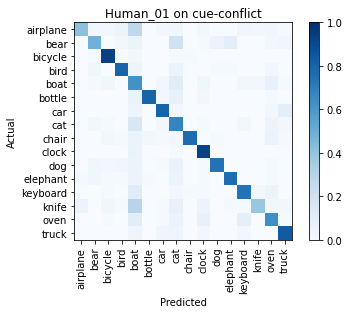

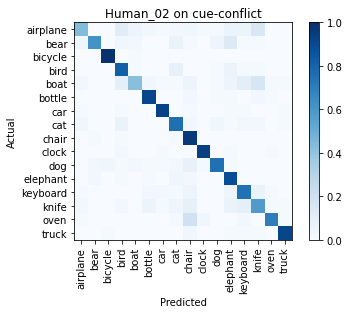

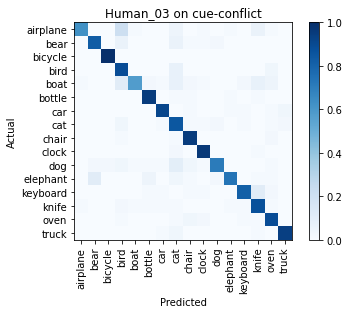

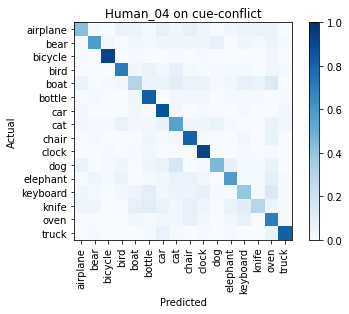

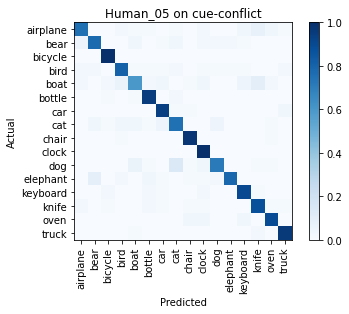

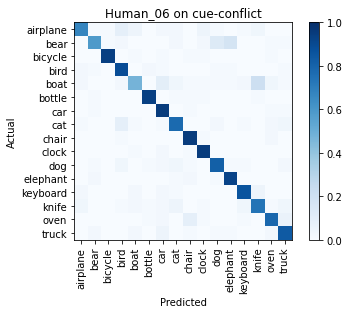

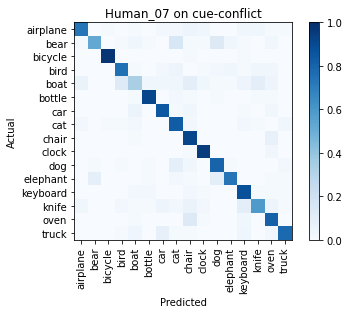

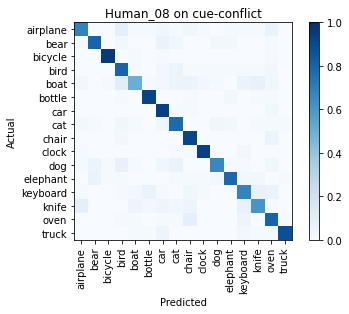

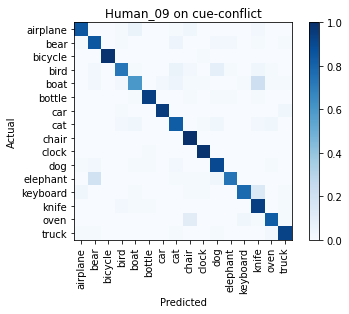

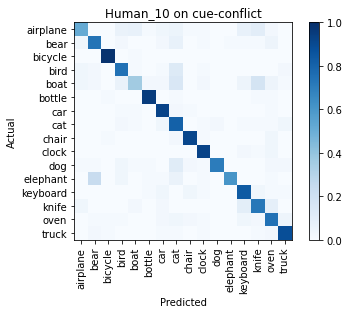

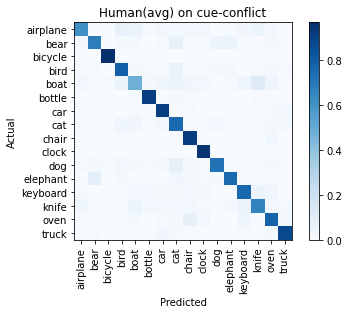

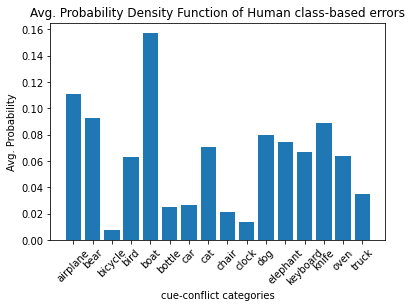

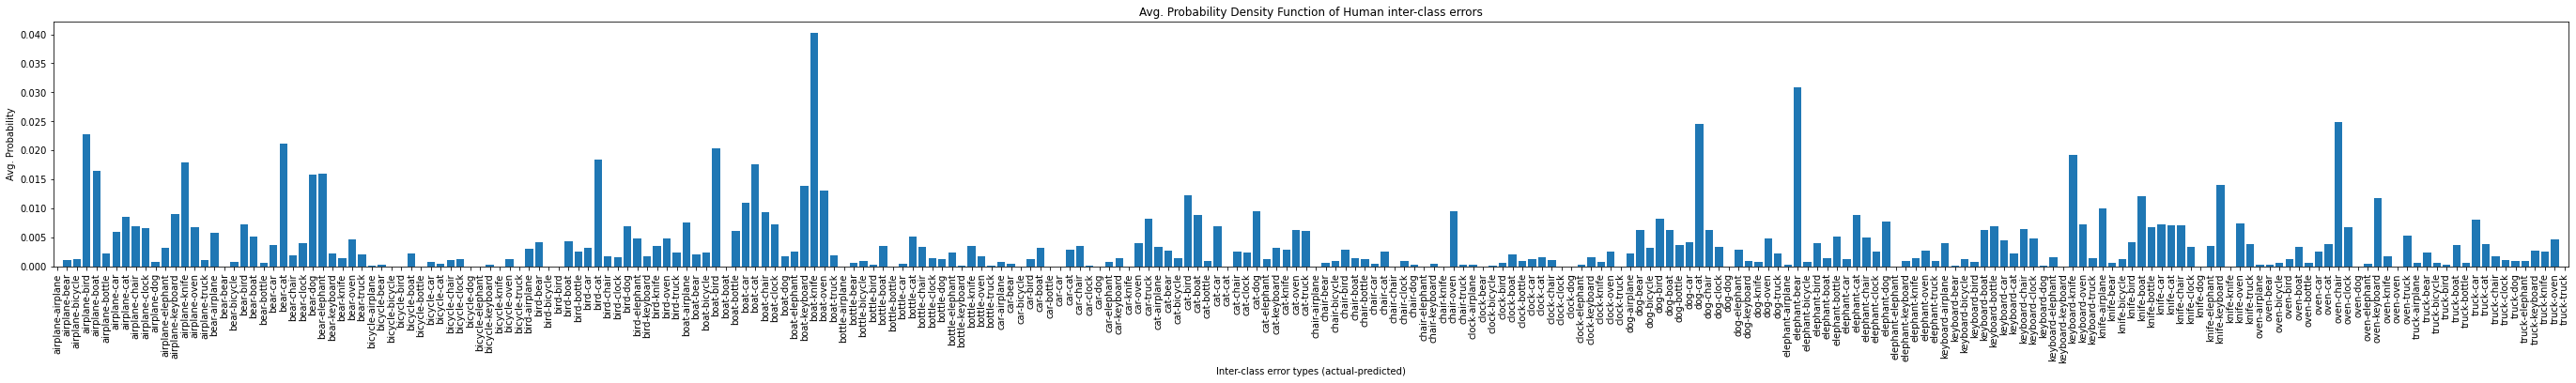

In [4]:
categories_SIN = os.listdir('../../texture-vs-shape/stimuli/style-transfer-preprocessed-512/')
categories_SIN.sort()

class_pdf_list = []
inter_pdf_list = []
misclassification_human = {}
cm_norm_list = []
cm_norm_dict = {}

for i in range(len(categories_SIN)):
  misclassification_human[categories_SIN[i]] = 0

for sub in range(1, 11):
  str_sub = '0'+str(sub) if sub < 10 else str(sub)
  human_csv = pd.read_csv(f'./texture-shape_{experiment}/texture-shape_{experiment}_subject-{str_sub}_session_1.csv')
  pred = human_csv['object_response']
  true = human_csv['category']

  cm = confusion_matrix(true, pred, labels = categories_SIN)
  cm_norm = confusion_matrix(true, pred, labels = categories_SIN, normalize = 'true')

  cm_norm_list.append(cm_norm)

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)

  for i in range(len(categories_SIN)):
    misclassification_human[categories_SIN[i]] += cm_errors[i, [j for j in range(len(categories_SIN)) if j != i]]

  class_pdf_errors = np.sum(cm_errors, axis = 1)
  class_pdf_errors = np.divide(class_pdf_errors, np.sum(class_pdf_errors))
  class_pdf_list.append(class_pdf_errors)
  inter_pdf_errors = np.divide(cm_errors, np.sum(cm_errors)).reshape(-1)
  inter_pdf_list.append(inter_pdf_errors)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues', vmax = 1)
  plt.title(f'Human_{str_sub} on {experiment}')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

class_pdf_avg = np.zeros_like(class_pdf_errors)
inter_pdf_avg = np.zeros_like(inter_pdf_errors)
cm_norm_avg = np.zeros_like(cm_norm)
for i in range(10):
  class_pdf_avg += class_pdf_list[i]
  cm_norm_avg += cm_norm_list[i]
class_pdf_avg = np.divide(class_pdf_avg, 10)
cm_norm_avg = np.divide(cm_norm_avg, 10)

for i in range(10):
  inter_pdf_avg += inter_pdf_list[i]
inter_pdf_avg = np.divide(inter_pdf_avg, 10)

for i in range(len(categories_SIN)):
  misclassification_human[categories_SIN[i]] = np.divide(misclassification_human[categories_SIN[i]], 10)

human_class_pdf = class_pdf_avg
human_inter_pdf = inter_pdf_avg

cm_norm_dict['Human_avg'] = cm_norm_avg

fig, ax = plt.subplots()
plt.imshow(cm_norm_avg, cmap = 'Blues')
plt.title(f'Human(avg) on {experiment}')
plt.colorbar()
ax.set_xticks(np.arange(16))
ax.set_yticks(np.arange(16))
ax.set_xticklabels(categories_SIN, rotation=90)
ax.set_yticklabels(categories_SIN)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

fig = plt.figure()
plt.bar(categories_SIN, class_pdf_avg)
plt.xticks(rotation = 45)
plt.xlabel(f'{experiment} categories')
plt.ylabel('Avg. Probability')
plt.title('Avg. Probability Density Function of Human class-based errors')
plt.show()

fig = plt.figure(figsize=[48, 4.8])
plt.bar([str(c1+'-'+c2) for c1, c2 in itertools.product(categories_SIN, categories_SIN)], inter_pdf_avg)
plt.xticks(rotation = 90)
plt.xlabel('Inter-class error types (actual-predicted)')
plt.ylabel('Avg. Probability')
plt.title('Avg. Probability Density Function of Human inter-class errors')
plt.margins(x=0,tight=True)
plt.show()

### Define distance metric

In [5]:
def kl_distance(p, q):
  non_zero_indices = np.intersect1d(np.where(p!=0)[0], np.where(q!=0)[0])
  return np.sum([p[i] * np.log(p[i] / q[i]) for i in non_zero_indices])

def cross_entropy(p, q):
	return -np.sum(np.where(p != 0, p * np.log(q), 0))
 
def mse(p, q):
  return np.square(np.subtract(p,q)).mean() 

def js_distance(p, q):
  return jensenshannon(p, q)

### Generate ViT confusion matrices

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


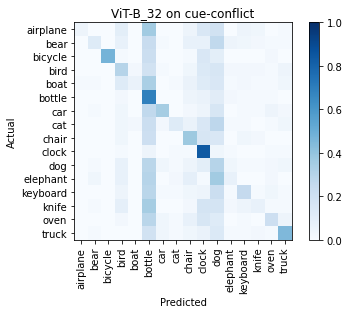

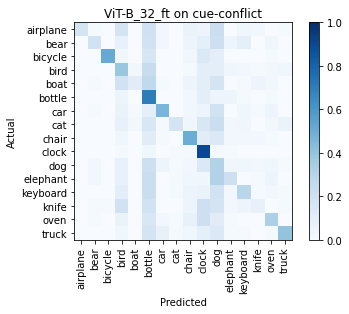

In [6]:
# vit_models = ['B_32', 'B_16', 'L_32', 'L_16', 'B_32_ft']
vit_models = ['B_32', 'B_32_ft']

kl_dist_class = {}
kl_dist_inter = {}

ce_dist_class = {}
ce_dist_inter = {}

js_dist_class = {}
js_dist_inter = {}

mse_misclassification = {}
js_misclassification = {}

acc_exp = {}

for model in vit_models:
  vit_csv = pd.read_csv(f'./texture-shape_{experiment}/texture-shape_{experiment}_ViT-{model}_session-1.csv')
  pred = vit_csv['object_response']
  true = vit_csv['category']

  cm = confusion_matrix(true, pred, labels = categories_SIN)
  cm_norm = confusion_matrix(true, pred, labels = categories_SIN, normalize = 'true')

  if model == 'B_32': cm_norm_dict[f'ViT-{model}'] = cm_norm
  if model == 'B_32_ft': cm_norm_dict[f'ViT-{model}'] = cm_norm

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)

  misclassification_error = {}

  for i in range(len(categories_SIN)):
    misclassification_error[categories_SIN[i]] = cm_errors[i, [j for j in range(len(categories_SIN)) if j != i]]

  mse_misclassification[f'ViT-{model}'] = {category:mse(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}
  js_misclassification[f'ViT-{model}'] = {category:js_distance(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}

  class_pdf_errors = np.sum(cm_errors, axis = 1)
  class_pdf_errors = np.divide(class_pdf_errors, np.sum(class_pdf_errors))
  inter_pdf_errors = np.divide(cm_errors, np.sum(cm_errors)).reshape(-1)

  kl_dist_class[f'ViT-{model}'] = kl_distance(class_pdf_errors, human_class_pdf)
  kl_dist_inter[f'ViT-{model}'] = kl_distance(inter_pdf_errors, human_inter_pdf)

  ce_dist_class[f'ViT-{model}'] = cross_entropy(class_pdf_errors, human_class_pdf)
  ce_dist_inter[f'ViT-{model}'] = cross_entropy(inter_pdf_errors, human_inter_pdf)

  js_dist_class[f'ViT-{model}'] = js_distance(class_pdf_errors, human_class_pdf)
  js_dist_inter[f'ViT-{model}'] = js_distance(inter_pdf_errors, human_inter_pdf)

  acc_exp[f'ViT-{model}'] = accuracy_score(true, pred)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues', vmax = 1)
  plt.title(f'ViT-{model} on {experiment}')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

### Generate ResNet confusion matrices

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


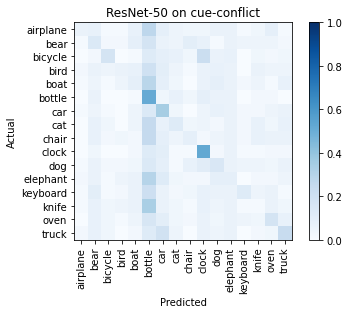

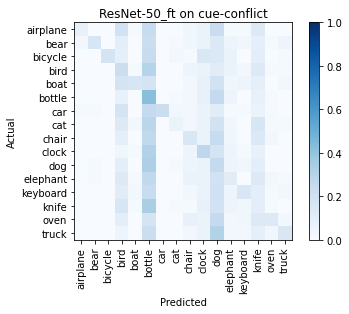

In [7]:
resnet_models = ['resnet50', 'resnet50_ft']

for model in resnet_models:
  resnet_csv = pd.read_csv(f'./texture-shape_{experiment}/texture-shape_{experiment}_{model}_session-1.csv')
  pred = resnet_csv['object_response']
  true = resnet_csv['category']

  cm = confusion_matrix(true, pred, labels = categories_SIN)
  cm_norm = confusion_matrix(true, pred, labels = categories_SIN, normalize = 'true')

  if model == 'resnet50': cm_norm_dict[f'ResNet-50{model[8:]}'] = cm_norm
  if model == 'resnet50_ft': cm_norm_dict[f'ResNet-50{model[8:]}'] = cm_norm

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)

  misclassification_error = {}

  for i in range(len(categories_SIN)):
    misclassification_error[categories_SIN[i]] = cm_errors[i, [j for j in range(len(categories_SIN)) if j != i]]

  mse_misclassification[f'ResNet-50{model[8:]}'] = {category:mse(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}
  js_misclassification[f'ResNet-50{model[8:]}'] = {category:js_distance(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}

  class_pdf_errors = np.sum(cm_errors, axis = 1)
  class_pdf_errors = np.divide(class_pdf_errors, np.sum(class_pdf_errors))
  inter_pdf_errors = np.divide(cm_errors, np.sum(cm_errors)).reshape(-1)

  kl_dist_class[f'ResNet-50{model[8:]}'] = kl_distance(class_pdf_errors, human_class_pdf)
  kl_dist_inter[f'ResNet-50{model[8:]}'] = kl_distance(inter_pdf_errors, human_inter_pdf)

  ce_dist_class[f'ResNet-50{model[8:]}'] = cross_entropy(class_pdf_errors, human_class_pdf)
  ce_dist_inter[f'ResNet-50{model[8:]}'] = cross_entropy(inter_pdf_errors, human_inter_pdf)

  js_dist_class[f'ResNet-50{model[8:]}'] = js_distance(class_pdf_errors, human_class_pdf)
  js_dist_inter[f'ResNet-50{model[8:]}'] = js_distance(inter_pdf_errors, human_inter_pdf)

  acc_exp[f'ResNet-50{model[8:]}'] = accuracy_score(true, pred)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues', vmax = 1)
  plt.title(f'ResNet-50{model[8:]} on {experiment}')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

### Plot relevant confusion matrices together

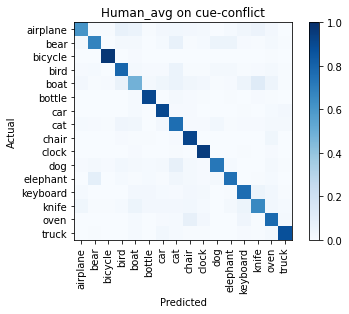

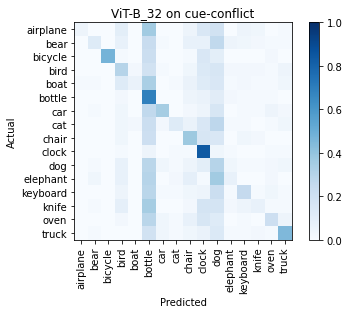

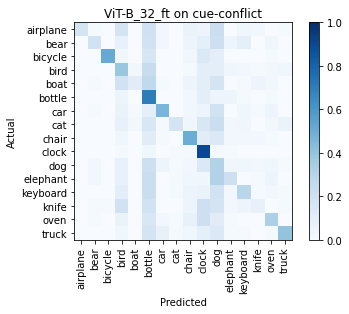

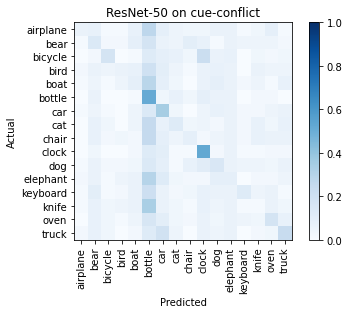

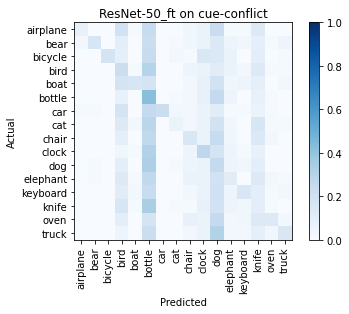

In [8]:
for model in cm_norm_dict.keys():
  
  fig, ax = plt.subplots()
  plt.imshow(cm_norm_dict[model], cmap = 'Blues', vmax = 1)
  plt.title(f'{model} on {experiment}')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

### Plot KL distance for class-wise errors

Model: ViT-B_32, 	 KL-Distance: 0.108
Model: ViT-B_32_ft, 	 KL-Distance: 0.101
Model: ResNet-50, 	 KL-Distance: 0.185
Model: ResNet-50_ft, 	 KL-Distance: 0.224


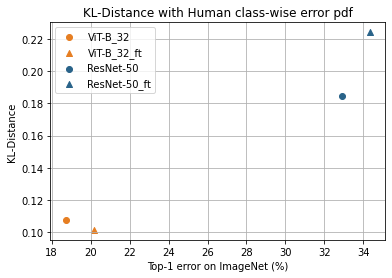

In [9]:
colors_bars = ['#F1C40F', '#E67E22', '#4292C6', '#296389']
colors_scatter = {'ViT-B_32': '#E67E22', 'ViT-B_32_ft': '#E67E22', 'ResNet-50': '#296389', 'ResNet-50_ft': '#296389'}

for model in kl_dist_class.keys():
  if PLOT_IMAGENET_ACC:
    plt.scatter((1-acc_im[model])*100, kl_dist_class[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, kl_dist_class[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  print(f'Model: {model}, \t KL-Distance: {kl_dist_class[model]:0.3f}')

plt.grid()
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)')
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)')
plt.ylabel('KL-Distance')
plt.title('KL-Distance with Human class-wise error pdf')
plt.legend()
plt.show()

### Plot KL distance for inter-class errors

Model: ViT-B_32, 	 KL-Distance: 1.170
Model: ViT-B_32_ft, 	 KL-Distance: 1.106
Model: ResNet-50, 	 KL-Distance: 0.789
Model: ResNet-50_ft, 	 KL-Distance: 1.145


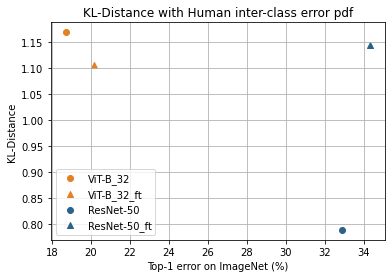

In [10]:
for model in kl_dist_inter.keys():
  if PLOT_IMAGENET_ACC:
    plt.scatter((1-acc_im[model])*100, kl_dist_inter[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, kl_dist_inter[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  print(f'Model: {model}, \t KL-Distance: {kl_dist_inter[model]:0.3f}')

plt.grid()
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)')
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)')
plt.ylabel('KL-Distance')
plt.title('KL-Distance with Human inter-class error pdf')
plt.legend()
plt.show()

### Plot cross-entropy of class-wise errors

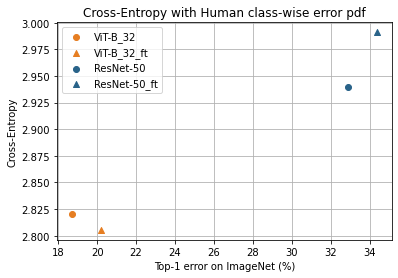

In [11]:
for model in ce_dist_class.keys():
  if PLOT_IMAGENET_ACC:
    plt.scatter((1-acc_im[model])*100, ce_dist_class[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  else:  
    plt.scatter((1-acc_exp[model])*100, ce_dist_class[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')

plt.grid()
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)')
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)')
plt.ylabel('Cross-Entropy')
plt.title('Cross-Entropy with Human class-wise error pdf')
plt.legend()
plt.show()

### Plot JS distance for class-wise errors

Model: ViT-B_32, 	 JS-Distance: 0.151
Model: ViT-B_32_ft, 	 JS-Distance: 0.147
Model: ResNet-50, 	 JS-Distance: 0.195
Model: ResNet-50_ft, 	 JS-Distance: 0.216


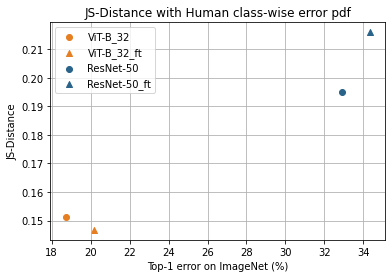

In [12]:
colors_bars = ['#F1C40F', '#E67E22', '#4292C6', '#296389']
colors_scatter = {'ViT-B_32': '#E67E22', 'ViT-B_32_ft': '#E67E22', 'ResNet-50': '#296389', 'ResNet-50_ft': '#296389'}

for model in js_dist_class.keys():
  if PLOT_IMAGENET_ACC:
    plt.scatter((1-acc_im[model])*100, js_dist_class[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, js_dist_class[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  print(f'Model: {model}, \t JS-Distance: {js_dist_class[model]:0.3f}')

plt.grid()
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)')
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)')
plt.ylabel('JS-Distance')
plt.title('JS-Distance with Human class-wise error pdf')
plt.legend()
plt.show()

### Plot JS distance for inter-class errors

Model: ViT-B_32, 	 JS-Distance: 0.553
Model: ViT-B_32_ft, 	 JS-Distance: 0.544
Model: ResNet-50, 	 JS-Distance: 0.460
Model: ResNet-50_ft, 	 JS-Distance: 0.568


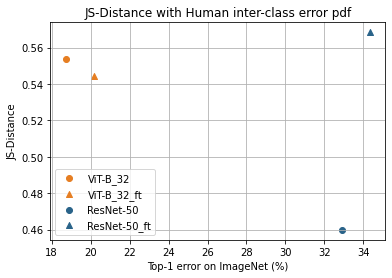

In [13]:
for model in js_dist_inter.keys():
  if PLOT_IMAGENET_ACC:
    plt.scatter((1-acc_im[model])*100, js_dist_inter[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, js_dist_inter[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  print(f'Model: {model}, \t JS-Distance: {js_dist_inter[model]:0.3f}')

plt.grid()
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)')
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)')
plt.ylabel('JS-Distance')
plt.title('JS-Distance with Human inter-class error pdf')
plt.legend()
plt.show()

### Plot MSE distance between misclassifications per class

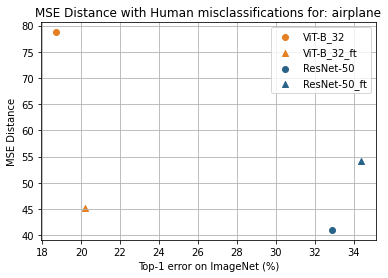

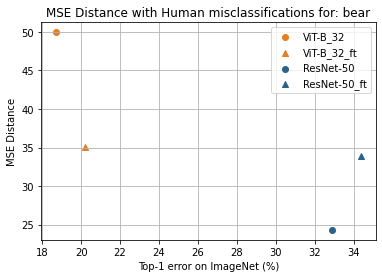

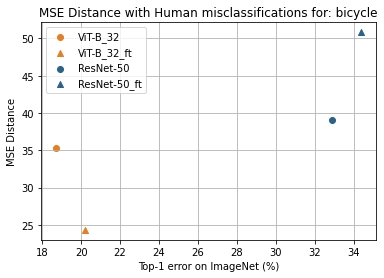

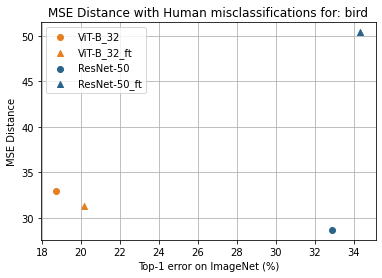

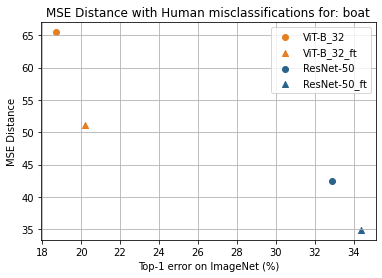

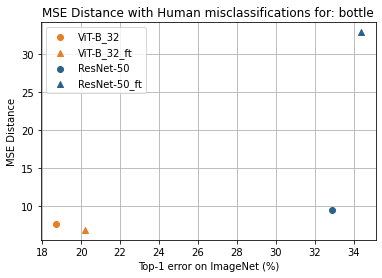

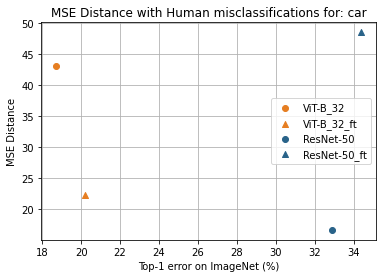

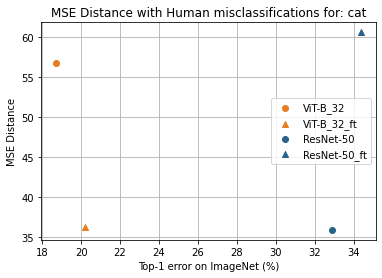

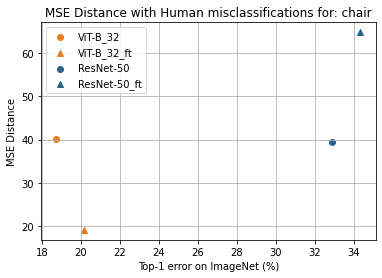

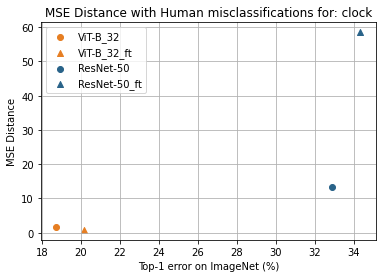

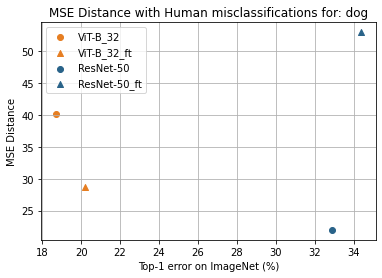

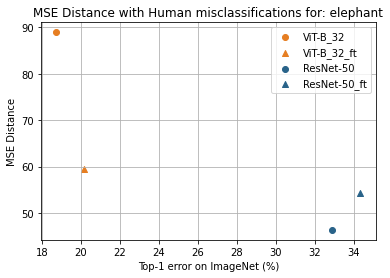

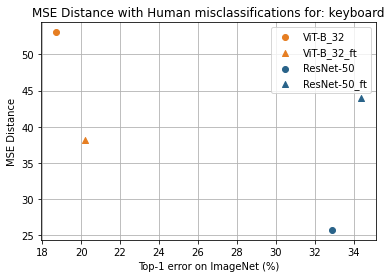

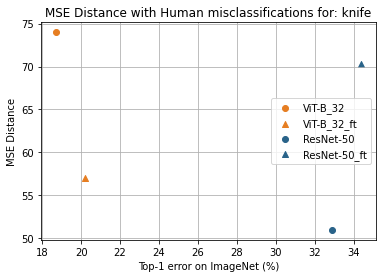

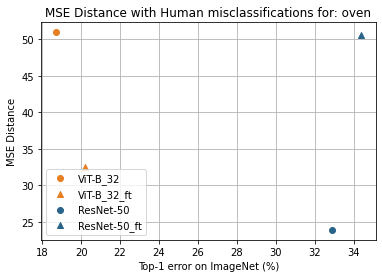

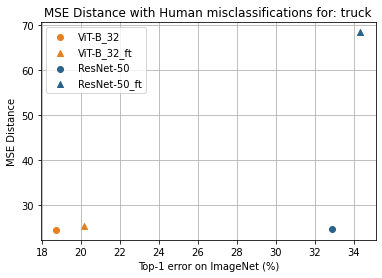

In [14]:
for category in categories_SIN:
  for model in mse_misclassification.keys():
    if PLOT_IMAGENET_ACC:
      plt.scatter((1-acc_im[model])*100, mse_misclassification[model][category], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')  
    else:
      plt.scatter((1-acc_exp[model])*100, mse_misclassification[model][category], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  
  plt.grid()
  if PLOT_IMAGENET_ACC:
    plt.xlabel(f'Top-1 error on ImageNet (%)')
  else:
    plt.xlabel(f'Top-1 error on {experiment} (%)')
  plt.ylabel('MSE Distance')
  plt.title(f'MSE Distance with Human misclassifications for: {category}')
  plt.legend()
  plt.show()

### Plot all MSE distances in one graph

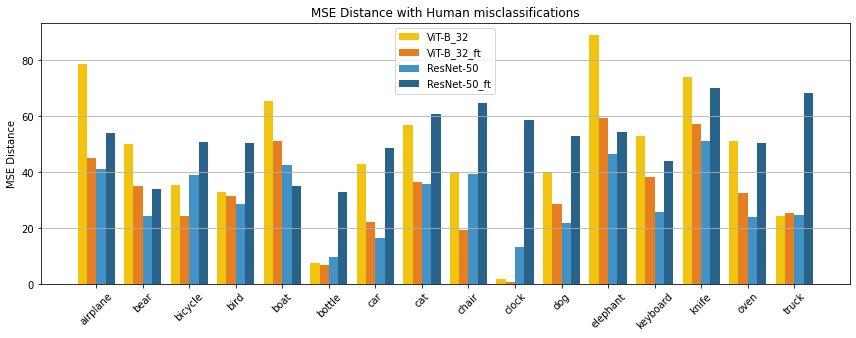

In [15]:
x = np.arange(len(categories_SIN))
width = 0.2

fig, ax = plt.subplots(figsize=[12, 4.8])

count = 0
for model in mse_misclassification.keys():
  rects = ax.bar(x - 3*width/2 + width*count, [mse_misclassification[model][cat] for cat in categories_SIN], width, label=model, color=colors_bars[count])
  count += 1

ax.set_ylabel('MSE Distance')
ax.set_title('MSE Distance with Human misclassifications')
ax.set_xticks(x)
plt.xticks(rotation=45)
ax.set_xticklabels(categories_SIN)
ax.legend()
fig.tight_layout()
plt.grid(axis = 'y')
plt.show()

### Plot JS distance between misclassifications per class

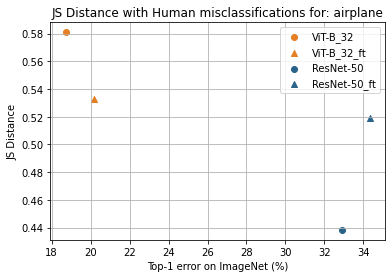

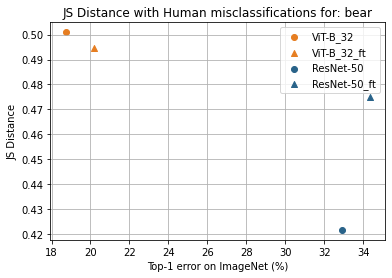

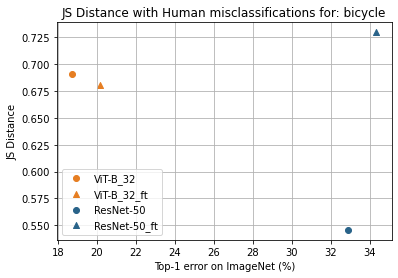

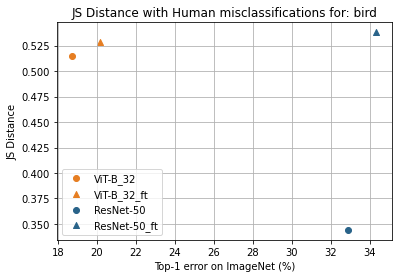

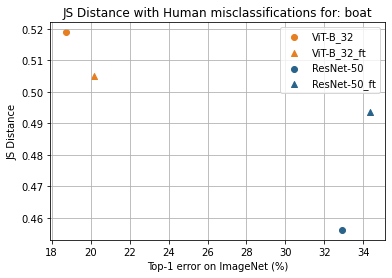

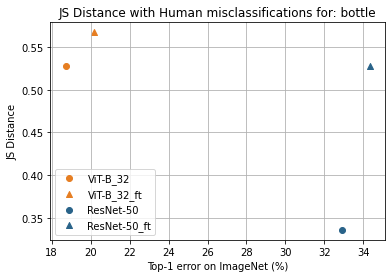

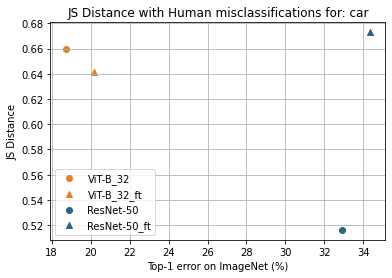

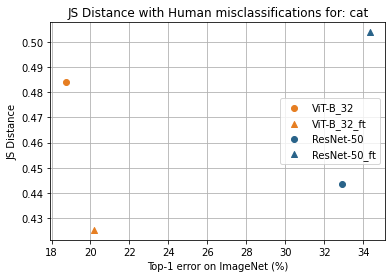

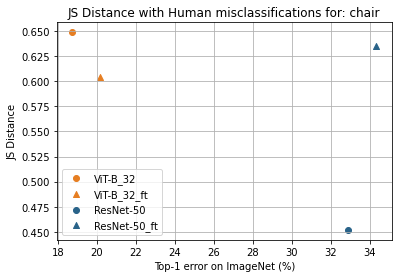

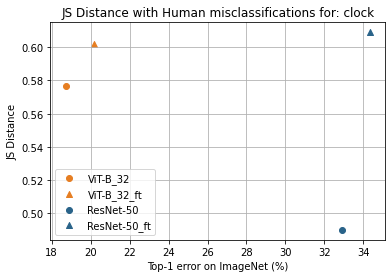

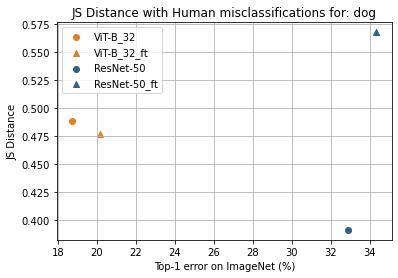

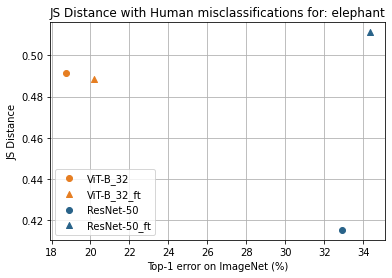

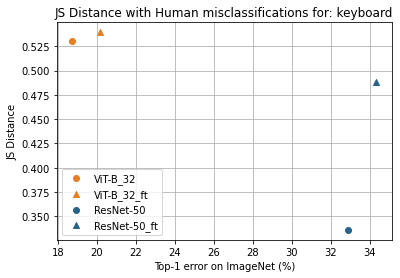

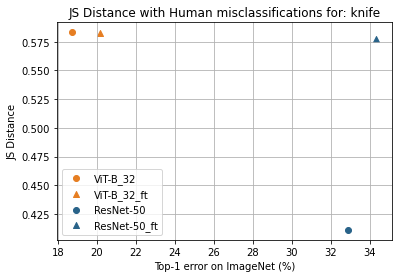

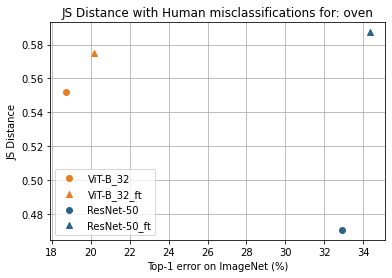

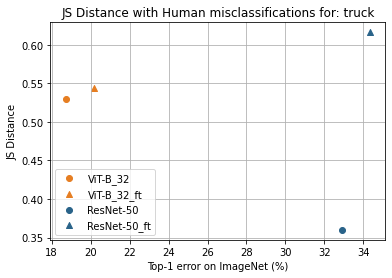

In [16]:
for category in categories_SIN:
  for model in js_misclassification.keys():
    if PLOT_IMAGENET_ACC:
      plt.scatter((1-acc_im[model])*100, js_misclassification[model][category], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')  
    else:
      plt.scatter((1-acc_exp[model])*100, js_misclassification[model][category], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  
  plt.grid()
  if PLOT_IMAGENET_ACC:
    plt.xlabel(f'Top-1 error on ImageNet (%)')
  else:
    plt.xlabel(f'Top-1 error on {experiment} (%)')
  plt.ylabel('JS Distance')
  plt.title(f'JS Distance with Human misclassifications for: {category}')
  plt.legend()
  plt.show()

### Plot all JS distances in one graph

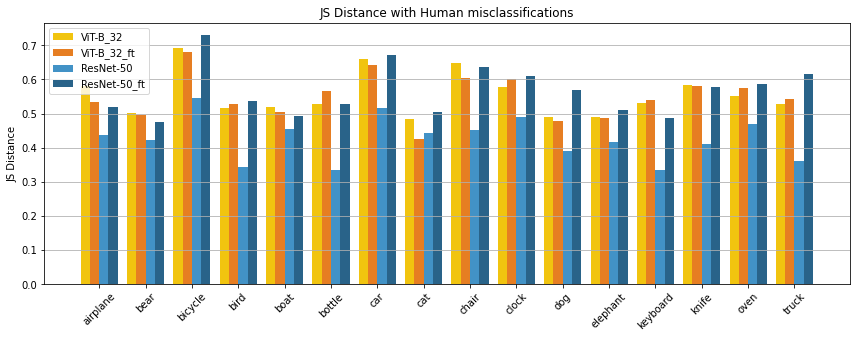

In [17]:
x = np.arange(len(categories_SIN))
width = 0.2

fig, ax = plt.subplots(figsize=[12, 4.8])

count = 0
for model in js_misclassification.keys():
  rects = ax.bar(x - 3*width/2 + width*count, [js_misclassification[model][cat] for cat in categories_SIN], width, label=model, color=colors_bars[count])
  count += 1

ax.set_ylabel('JS Distance')
ax.set_title('JS Distance with Human misclassifications')
ax.set_xticks(x)
plt.xticks(rotation=45)
ax.set_xticklabels(categories_SIN)
ax.legend()
fig.tight_layout()
plt.grid(axis = 'y')
plt.show()

### Plot correlation with Cohen's Kappa

Model: ViT-B_32, 	 JS-Distance: 0.151, 	 Cohen's Kappa: 0.137
Model: ViT-B_32_ft, 	 JS-Distance: 0.147, 	 Cohen's Kappa: 0.156
Model: ResNet-50, 	 JS-Distance: 0.195, 	 Cohen's Kappa: 0.068
Model: ResNet-50_ft, 	 JS-Distance: 0.216, 	 Cohen's Kappa: 0.030


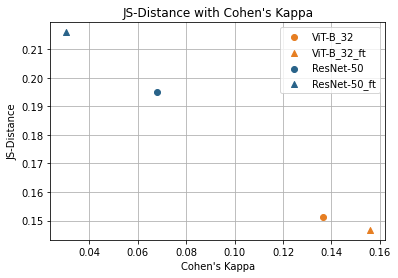

In [18]:
cohens_k = {}

cohens_csv = pd.read_csv(f'../figures_new_ft/texture-shape_{experiment}/texture-shape_{experiment}_kappa.csv')

for model in js_dist_class.keys():
  cohens_k[model] = np.mean(cohens_csv[model])

for model in js_dist_class.keys():
  plt.scatter(cohens_k[model], js_dist_class[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  print(f'Model: {model}, \t JS-Distance: {js_dist_class[model]:0.3f}, \t Cohen\'s Kappa: {cohens_k[model]:0.3f}')

plt.grid()
plt.xlabel('Cohen\'s Kappa')
plt.ylabel('JS-Distance')
plt.title('JS-Distance with Cohen\'s Kappa')
plt.legend()
plt.show()

## Experiment 2: Edges




In [19]:
experiment = 'edges'

### Generate Human confusion matrices

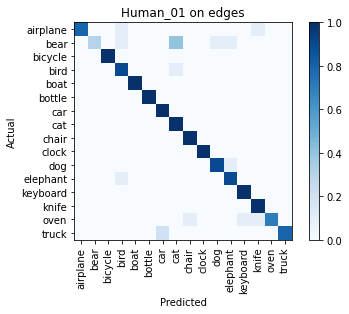

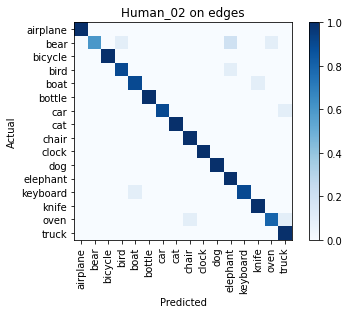

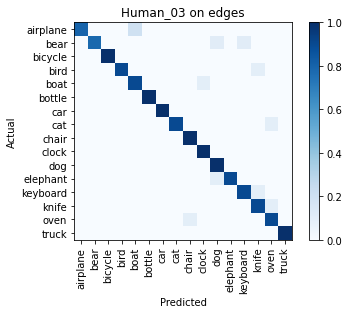

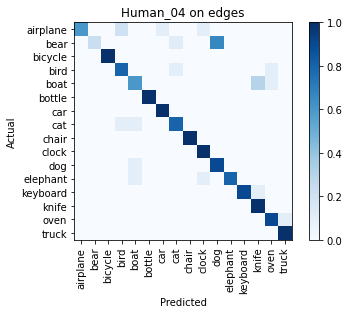

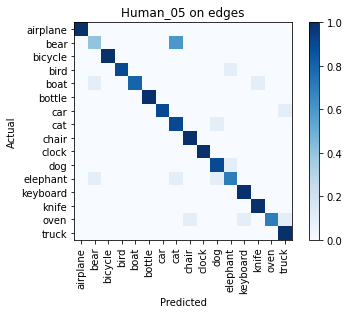

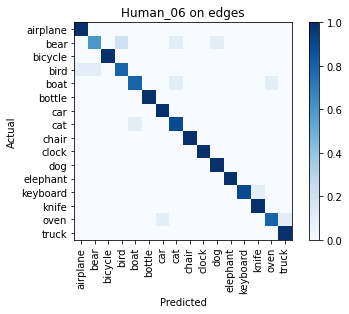

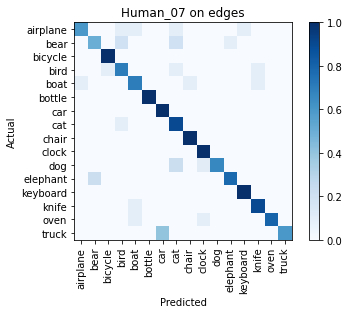

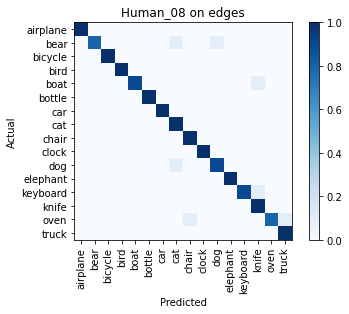

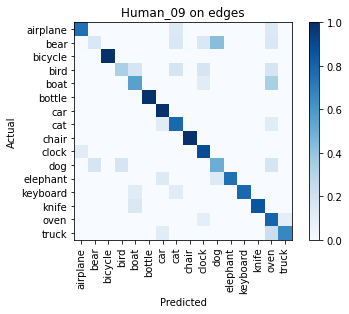

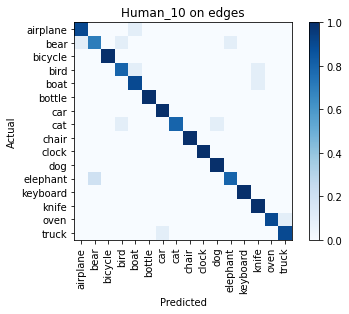

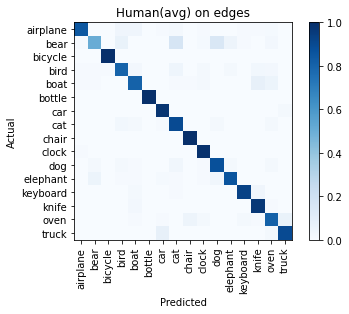

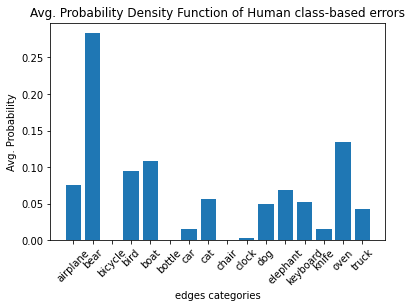

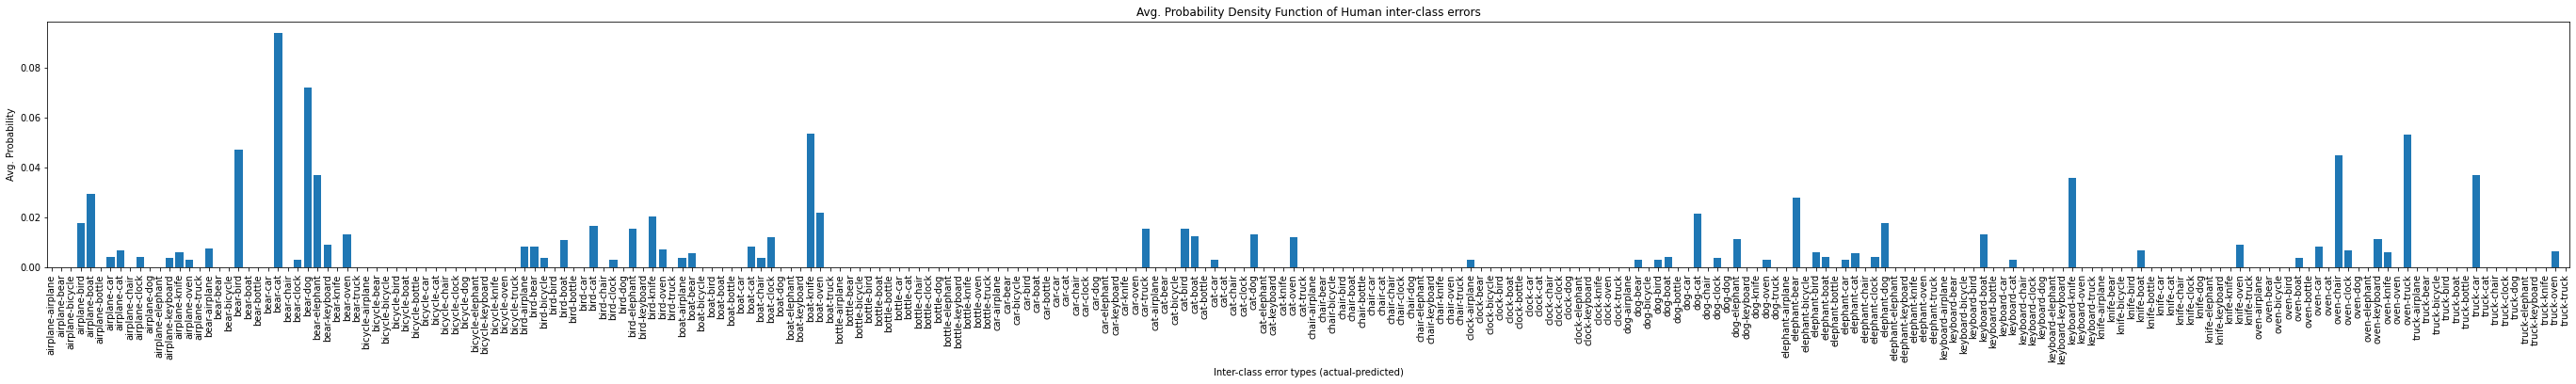

In [20]:
categories_SIN = os.listdir('../../texture-vs-shape/stimuli/style-transfer-preprocessed-512/')
categories_SIN.sort()

class_pdf_list = []
inter_pdf_list = []
misclassification_human = {}
cm_norm_list = []
cm_norm_dict = {}

for i in range(len(categories_SIN)):
  misclassification_human[categories_SIN[i]] = 0

for sub in range(1, 11):
  str_sub = '0'+str(sub) if sub < 10 else str(sub)
  human_csv = pd.read_csv(f'./texture-shape_{experiment}/texture-shape_{experiment}_subject-{str_sub}_session_1.csv')
  pred = human_csv['object_response']
  true = human_csv['category']

  cm = confusion_matrix(true, pred, labels = categories_SIN)
  cm_norm = confusion_matrix(true, pred, labels = categories_SIN, normalize = 'true')

  cm_norm_list.append(cm_norm)

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)

  for i in range(len(categories_SIN)):
    misclassification_human[categories_SIN[i]] += cm_errors[i, [j for j in range(len(categories_SIN)) if j != i]]

  class_pdf_errors = np.sum(cm_errors, axis = 1)
  class_pdf_errors = np.divide(class_pdf_errors, np.sum(class_pdf_errors))
  class_pdf_list.append(class_pdf_errors)
  inter_pdf_errors = np.divide(cm_errors, np.sum(cm_errors)).reshape(-1)
  inter_pdf_list.append(inter_pdf_errors)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues', vmax = 1)
  plt.title(f'Human_{str_sub} on {experiment}')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

class_pdf_avg = np.zeros_like(class_pdf_errors)
inter_pdf_avg = np.zeros_like(inter_pdf_errors)
cm_norm_avg = np.zeros_like(cm_norm)
for i in range(10):
  class_pdf_avg += class_pdf_list[i]
  cm_norm_avg += cm_norm_list[i]
class_pdf_avg = np.divide(class_pdf_avg, 10)
cm_norm_avg = np.divide(cm_norm_avg, 10)

for i in range(10):
  inter_pdf_avg += inter_pdf_list[i]
inter_pdf_avg = np.divide(inter_pdf_avg, 10)

for i in range(len(categories_SIN)):
  misclassification_human[categories_SIN[i]] = np.divide(misclassification_human[categories_SIN[i]], 10)

human_class_pdf = class_pdf_avg
human_inter_pdf = inter_pdf_avg

cm_norm_dict['Human_avg'] = cm_norm_avg

fig, ax = plt.subplots()
plt.imshow(cm_norm_avg, cmap = 'Blues')
plt.title(f'Human(avg) on {experiment}')
plt.colorbar()
ax.set_xticks(np.arange(16))
ax.set_yticks(np.arange(16))
ax.set_xticklabels(categories_SIN, rotation=90)
ax.set_yticklabels(categories_SIN)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

fig = plt.figure()
plt.bar(categories_SIN, class_pdf_avg)
plt.xticks(rotation = 45)
plt.xlabel(f'{experiment} categories')
plt.ylabel('Avg. Probability')
plt.title('Avg. Probability Density Function of Human class-based errors')
plt.show()

fig = plt.figure(figsize=[48, 4.8])
plt.bar([str(c1+'-'+c2) for c1, c2 in itertools.product(categories_SIN, categories_SIN)], inter_pdf_avg)
plt.xticks(rotation = 90)
plt.xlabel('Inter-class error types (actual-predicted)')
plt.ylabel('Avg. Probability')
plt.title('Avg. Probability Density Function of Human inter-class errors')
plt.margins(x=0,tight=True)
plt.show()

### Define distance metric

In [21]:
def kl_distance(p, q):
  non_zero_indices = np.intersect1d(np.where(p!=0)[0], np.where(q!=0)[0])
  return np.sum([p[i] * np.log(p[i] / q[i]) for i in non_zero_indices])

def cross_entropy(p, q):
	return -np.sum(np.where(p != 0, p * np.log(q), 0))
 
def mse(p, q):
  return np.square(np.subtract(p,q)).mean() 

def js_distance(p, q):
  return jensenshannon(p, q)

### Generate ViT confusion matrices

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:1289: RuntimeWarning: invalid value encountered in true_divide
  q = q / np.sum(q, axis=0)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:1288: RuntimeWarning: invalid value encountered in true_divide
  p = p / np.sum(p, axis=0)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


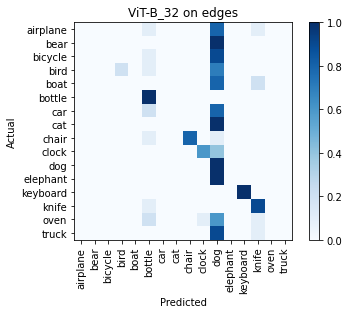

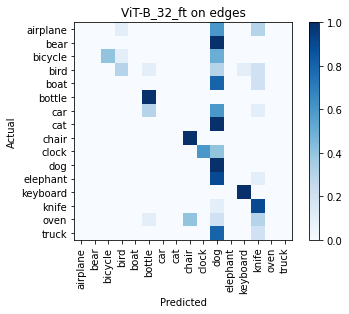

In [22]:
# vit_models = ['B_32', 'B_16', 'L_32', 'L_16', 'B_32_ft']
vit_models = ['B_32', 'B_32_ft']

kl_dist_class = {}
kl_dist_inter = {}

ce_dist_class = {}
ce_dist_inter = {}

js_dist_class = {}
js_dist_inter = {}

mse_misclassification = {}
js_misclassification = {}

acc_exp = {}

for model in vit_models:
  vit_csv = pd.read_csv(f'./texture-shape_{experiment}/texture-shape_{experiment}_ViT-{model}_session-1.csv')
  pred = vit_csv['object_response']
  true = vit_csv['category']

  cm = confusion_matrix(true, pred, labels = categories_SIN)
  cm_norm = confusion_matrix(true, pred, labels = categories_SIN, normalize = 'true')

  if model == 'B_32': cm_norm_dict[f'ViT-{model}'] = cm_norm
  if model == 'B_32_ft': cm_norm_dict[f'ViT-{model}'] = cm_norm

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)

  misclassification_error = {}

  for i in range(len(categories_SIN)):
    misclassification_error[categories_SIN[i]] = cm_errors[i, [j for j in range(len(categories_SIN)) if j != i]]

  mse_misclassification[f'ViT-{model}'] = {category:mse(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}
  js_misclassification[f'ViT-{model}'] = {category:js_distance(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}

  class_pdf_errors = np.sum(cm_errors, axis = 1)
  class_pdf_errors = np.divide(class_pdf_errors, np.sum(class_pdf_errors))
  inter_pdf_errors = np.divide(cm_errors, np.sum(cm_errors)).reshape(-1)

  kl_dist_class[f'ViT-{model}'] = kl_distance(class_pdf_errors, human_class_pdf)
  kl_dist_inter[f'ViT-{model}'] = kl_distance(inter_pdf_errors, human_inter_pdf)

  ce_dist_class[f'ViT-{model}'] = cross_entropy(class_pdf_errors, human_class_pdf)
  ce_dist_inter[f'ViT-{model}'] = cross_entropy(inter_pdf_errors, human_inter_pdf)

  js_dist_class[f'ViT-{model}'] = js_distance(class_pdf_errors, human_class_pdf)
  js_dist_inter[f'ViT-{model}'] = js_distance(inter_pdf_errors, human_inter_pdf)

  acc_exp[f'ViT-{model}'] = accuracy_score(true, pred)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues', vmax = 1)
  plt.title(f'ViT-{model} on {experiment}')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

### Generate ResNet confusion matrices

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:1289: RuntimeWarning: invalid value encountered in true_divide
  q = q / np.sum(q, axis=0)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


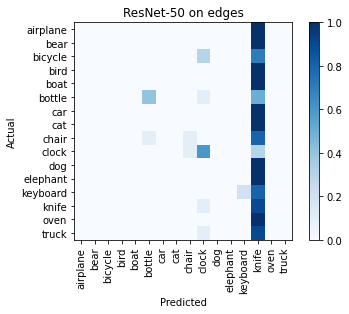

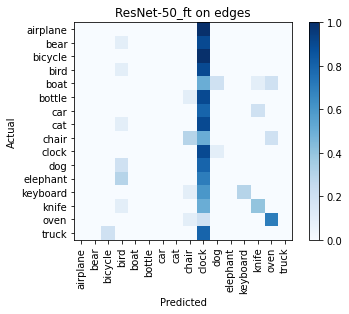

In [23]:
resnet_models = ['resnet50', 'resnet50_ft']

for model in resnet_models:
  resnet_csv = pd.read_csv(f'./texture-shape_{experiment}/texture-shape_{experiment}_{model}_session-1.csv')
  pred = resnet_csv['object_response']
  true = resnet_csv['category']

  cm = confusion_matrix(true, pred, labels = categories_SIN)
  cm_norm = confusion_matrix(true, pred, labels = categories_SIN, normalize = 'true')

  if model == 'resnet50': cm_norm_dict[f'ResNet-50{model[8:]}'] = cm_norm
  if model == 'resnet50_ft': cm_norm_dict[f'ResNet-50{model[8:]}'] = cm_norm

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)

  misclassification_error = {}

  for i in range(len(categories_SIN)):
    misclassification_error[categories_SIN[i]] = cm_errors[i, [j for j in range(len(categories_SIN)) if j != i]]

  mse_misclassification[f'ResNet-50{model[8:]}'] = {category:mse(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}
  js_misclassification[f'ResNet-50{model[8:]}'] = {category:js_distance(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}

  class_pdf_errors = np.sum(cm_errors, axis = 1)
  class_pdf_errors = np.divide(class_pdf_errors, np.sum(class_pdf_errors))
  inter_pdf_errors = np.divide(cm_errors, np.sum(cm_errors)).reshape(-1)

  kl_dist_class[f'ResNet-50{model[8:]}'] = kl_distance(class_pdf_errors, human_class_pdf)
  kl_dist_inter[f'ResNet-50{model[8:]}'] = kl_distance(inter_pdf_errors, human_inter_pdf)

  ce_dist_class[f'ResNet-50{model[8:]}'] = cross_entropy(class_pdf_errors, human_class_pdf)
  ce_dist_inter[f'ResNet-50{model[8:]}'] = cross_entropy(inter_pdf_errors, human_inter_pdf)

  js_dist_class[f'ResNet-50{model[8:]}'] = js_distance(class_pdf_errors, human_class_pdf)
  js_dist_inter[f'ResNet-50{model[8:]}'] = js_distance(inter_pdf_errors, human_inter_pdf)

  acc_exp[f'ResNet-50{model[8:]}'] = accuracy_score(true, pred)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues', vmax = 1)
  plt.title(f'ResNet-50{model[8:]} on {experiment}')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

### Plot relevant confusion matrices together

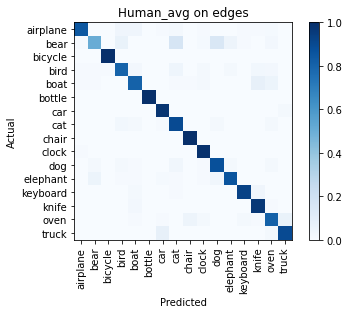

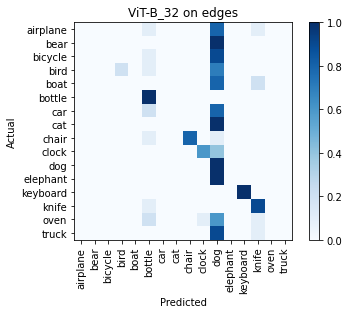

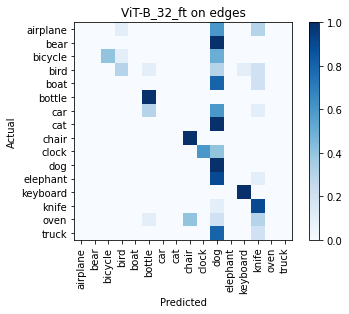

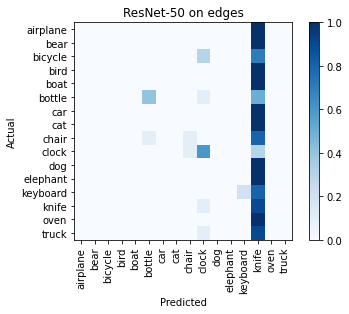

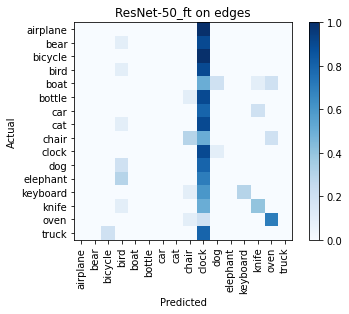

In [24]:
for model in cm_norm_dict.keys():
  
  fig, ax = plt.subplots()
  plt.imshow(cm_norm_dict[model], cmap = 'Blues', vmax = 1)
  plt.title(f'{model} on {experiment}')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

### Plot KL distance for class-wise errors

Model: ViT-B_32, 	 KL-Distance: 0.277
Model: ViT-B_32_ft, 	 KL-Distance: 0.354
Model: ResNet-50, 	 KL-Distance: 0.069
Model: ResNet-50_ft, 	 KL-Distance: 0.084


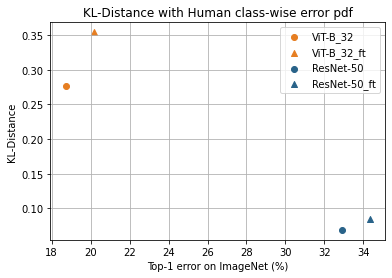

In [25]:
colors_bars = ['#F1C40F', '#E67E22', '#4292C6', '#296389']
colors_scatter = {'ViT-B_32': '#E67E22', 'ViT-B_32_ft': '#E67E22', 'ResNet-50': '#296389', 'ResNet-50_ft': '#296389'}

for model in kl_dist_class.keys():
  if PLOT_IMAGENET_ACC:
    plt.scatter((1-acc_im[model])*100, kl_dist_class[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, kl_dist_class[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  print(f'Model: {model}, \t KL-Distance: {kl_dist_class[model]:0.3f}')

plt.grid()
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)')
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)')
plt.ylabel('KL-Distance')
plt.title('KL-Distance with Human class-wise error pdf')
plt.legend()
plt.show()

### Plot KL distance for inter-class errors

Model: ViT-B_32, 	 KL-Distance: 0.367
Model: ViT-B_32_ft, 	 KL-Distance: 0.467
Model: ResNet-50, 	 KL-Distance: 0.506
Model: ResNet-50_ft, 	 KL-Distance: 0.992


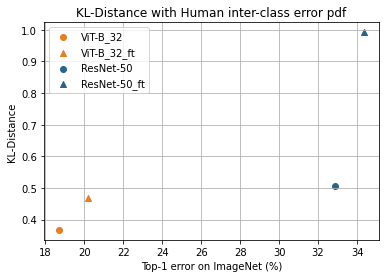

In [26]:
for model in kl_dist_inter.keys():
  if PLOT_IMAGENET_ACC:
    plt.scatter((1-acc_im[model])*100, kl_dist_inter[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, kl_dist_inter[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  print(f'Model: {model}, \t KL-Distance: {kl_dist_inter[model]:0.3f}')

plt.grid()
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)')
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)')
plt.ylabel('KL-Distance')
plt.title('KL-Distance with Human inter-class error pdf')
plt.legend()
plt.show()

### Plot cross-entropy of class-wise errors

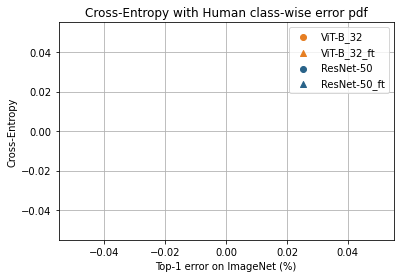

In [27]:
for model in ce_dist_class.keys():
  if PLOT_IMAGENET_ACC:
    plt.scatter((1-acc_im[model])*100, ce_dist_class[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  else:  
    plt.scatter((1-acc_exp[model])*100, ce_dist_class[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')

plt.grid()
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)')
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)')
plt.ylabel('Cross-Entropy')
plt.title('Cross-Entropy with Human class-wise error pdf')
plt.legend()
plt.show()

### Plot JS distance for class-wise errors

Model: ViT-B_32, 	 JS-Distance: 0.369
Model: ViT-B_32_ft, 	 JS-Distance: 0.347
Model: ResNet-50, 	 JS-Distance: 0.352
Model: ResNet-50_ft, 	 JS-Distance: 0.382


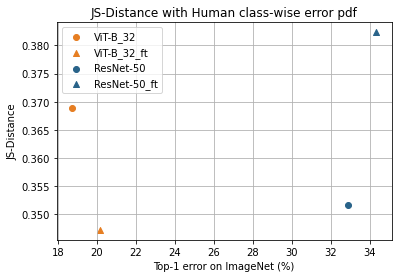

In [28]:
colors_bars = ['#F1C40F', '#E67E22', '#4292C6', '#296389']
colors_scatter = {'ViT-B_32': '#E67E22', 'ViT-B_32_ft': '#E67E22', 'ResNet-50': '#296389', 'ResNet-50_ft': '#296389'}

for model in js_dist_class.keys():
  if PLOT_IMAGENET_ACC:
    plt.scatter((1-acc_im[model])*100, js_dist_class[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, js_dist_class[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  print(f'Model: {model}, \t JS-Distance: {js_dist_class[model]:0.3f}')

plt.grid()
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)')
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)')
plt.ylabel('JS-Distance')
plt.title('JS-Distance with Human class-wise error pdf')
plt.legend()
plt.show()

### Plot JS distance for inter-class errors

Model: ViT-B_32, 	 JS-Distance: 0.745
Model: ViT-B_32_ft, 	 JS-Distance: 0.706
Model: ResNet-50, 	 JS-Distance: 0.757
Model: ResNet-50_ft, 	 JS-Distance: 0.757


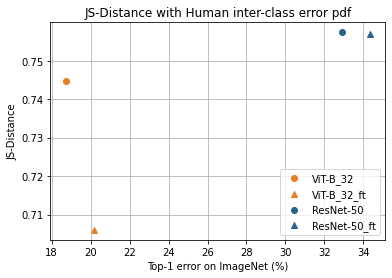

In [29]:
for model in js_dist_inter.keys():
  if PLOT_IMAGENET_ACC:
    plt.scatter((1-acc_im[model])*100, js_dist_inter[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, js_dist_inter[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  print(f'Model: {model}, \t JS-Distance: {js_dist_inter[model]:0.3f}')

plt.grid()
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)')
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)')
plt.ylabel('JS-Distance')
plt.title('JS-Distance with Human inter-class error pdf')
plt.legend()
plt.show()

### Plot MSE distance between misclassifications per class

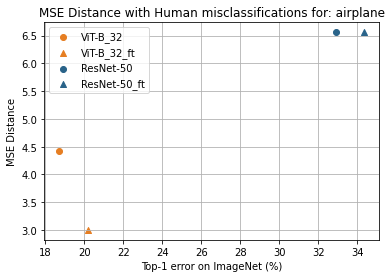

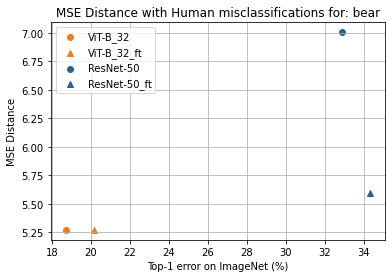

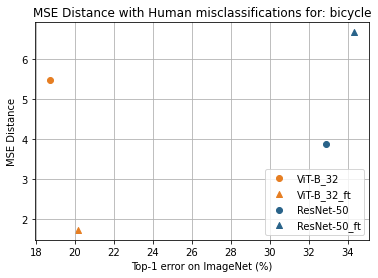

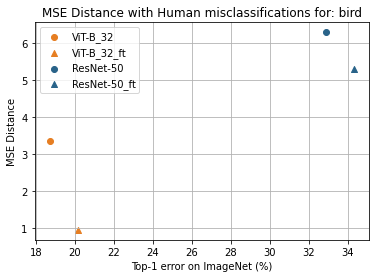

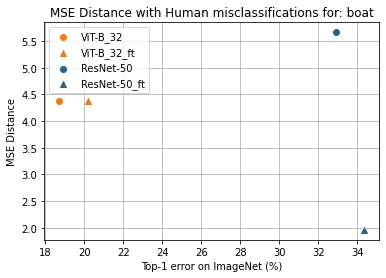

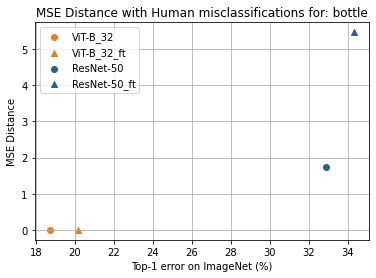

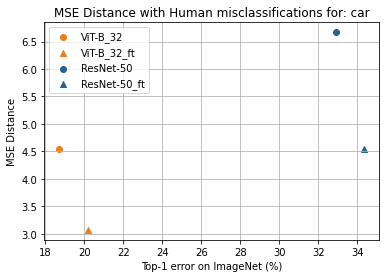

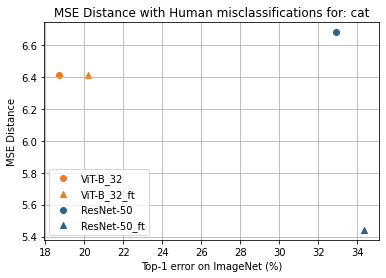

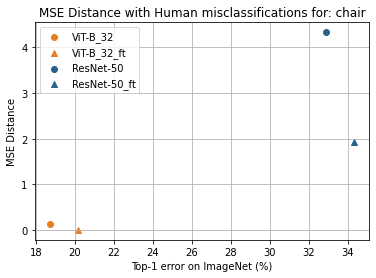

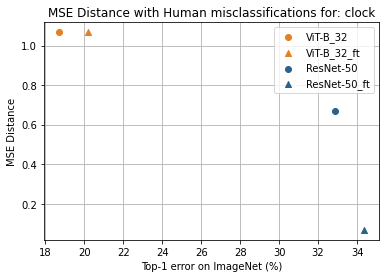

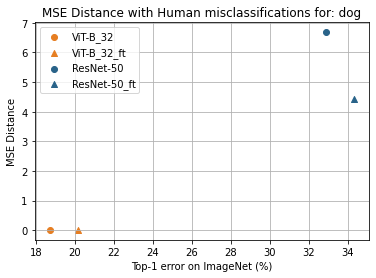

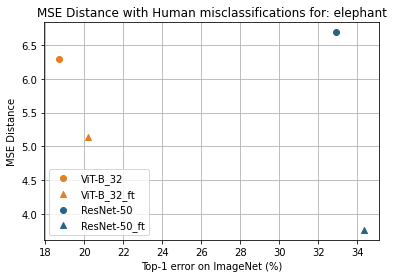

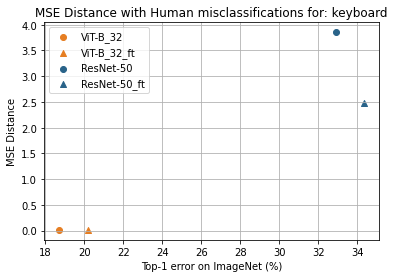

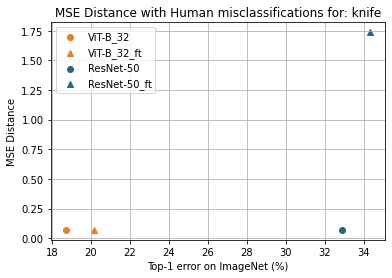

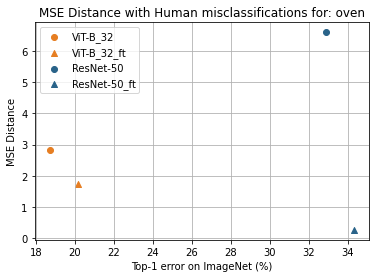

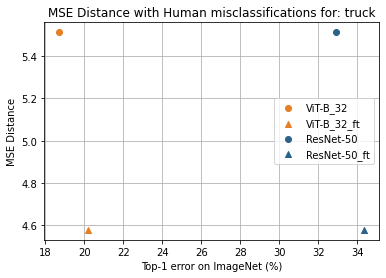

In [30]:
for category in categories_SIN:
  for model in mse_misclassification.keys():
    if PLOT_IMAGENET_ACC:
      plt.scatter((1-acc_im[model])*100, mse_misclassification[model][category], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')  
    else:
      plt.scatter((1-acc_exp[model])*100, mse_misclassification[model][category], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  
  plt.grid()
  if PLOT_IMAGENET_ACC:
    plt.xlabel(f'Top-1 error on ImageNet (%)')
  else:
    plt.xlabel(f'Top-1 error on {experiment} (%)')
  plt.ylabel('MSE Distance')
  plt.title(f'MSE Distance with Human misclassifications for: {category}')
  plt.legend()
  plt.show()

### Plot all MSE distances in one graph

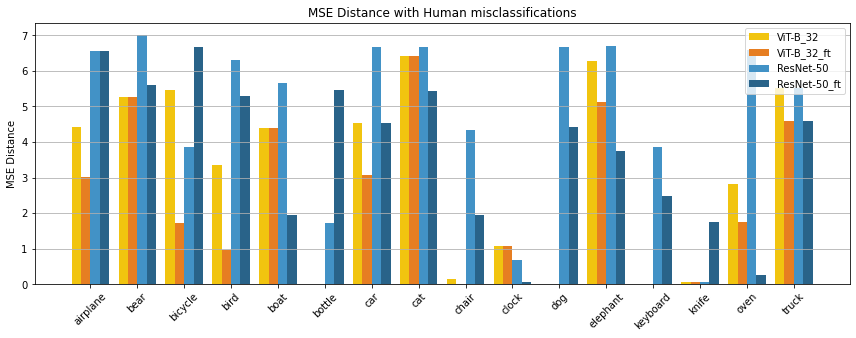

In [31]:
x = np.arange(len(categories_SIN))
width = 0.2

fig, ax = plt.subplots(figsize=[12, 4.8])

count = 0
for model in mse_misclassification.keys():
  rects = ax.bar(x - 3*width/2 + width*count, [mse_misclassification[model][cat] for cat in categories_SIN], width, label=model, color=colors_bars[count])
  count += 1

ax.set_ylabel('MSE Distance')
ax.set_title('MSE Distance with Human misclassifications')
ax.set_xticks(x)
plt.xticks(rotation=45)
ax.set_xticklabels(categories_SIN)
ax.legend()
fig.tight_layout()
plt.grid(axis = 'y')
plt.show()

### Plot JS distance between misclassifications per class

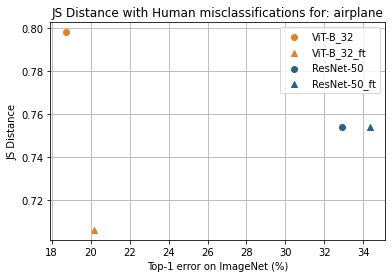

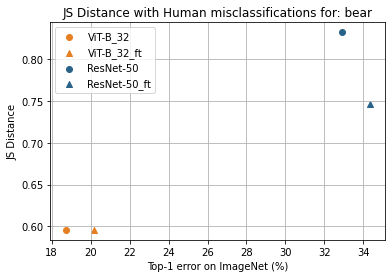

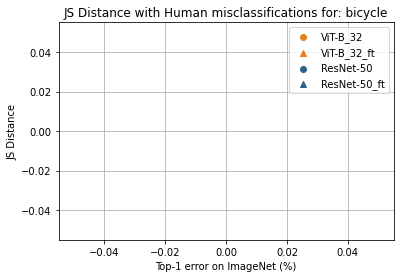

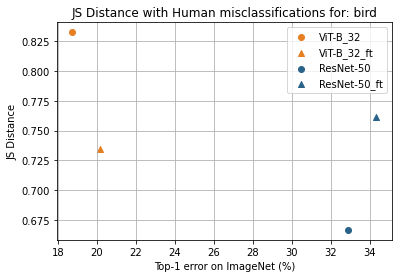

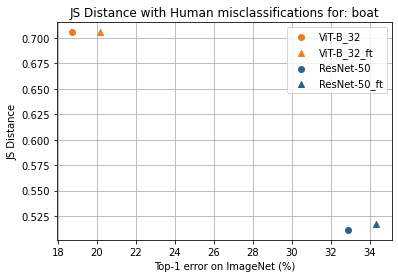

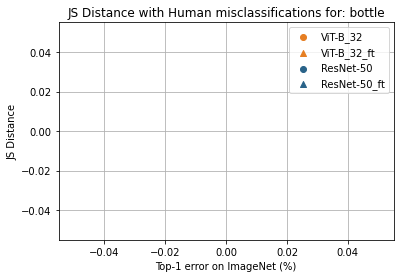

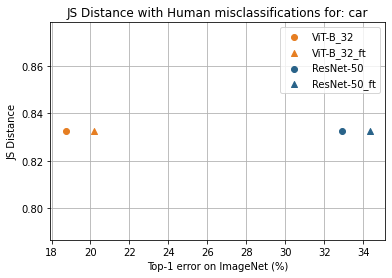

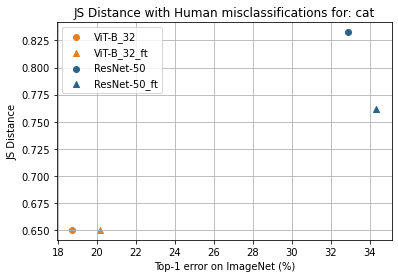

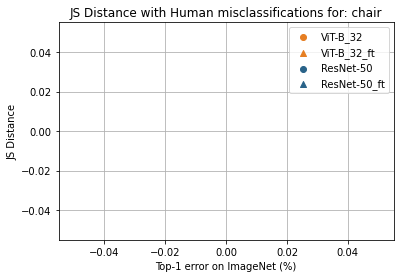

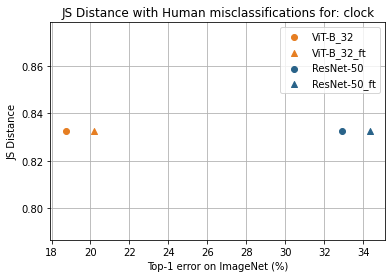

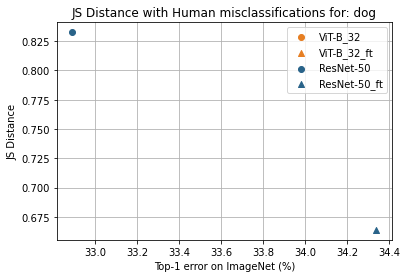

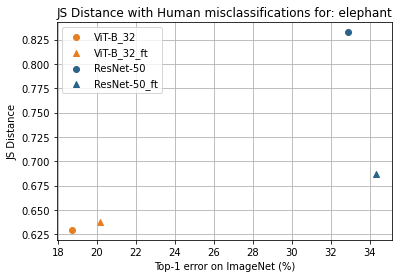

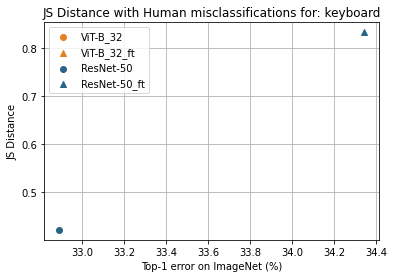

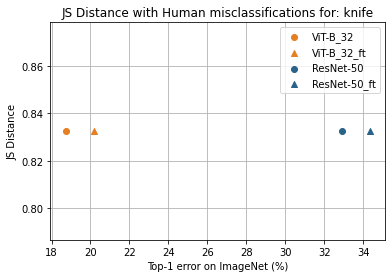

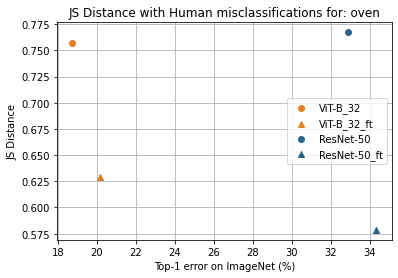

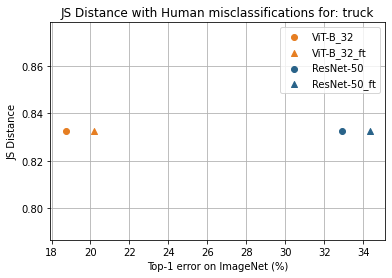

In [32]:
for category in categories_SIN:
  for model in js_misclassification.keys():
    if PLOT_IMAGENET_ACC:
      plt.scatter((1-acc_im[model])*100, js_misclassification[model][category], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')  
    else:
      plt.scatter((1-acc_exp[model])*100, js_misclassification[model][category], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  
  plt.grid()
  if PLOT_IMAGENET_ACC:
    plt.xlabel(f'Top-1 error on ImageNet (%)')
  else:
    plt.xlabel(f'Top-1 error on {experiment} (%)')
  plt.ylabel('JS Distance')
  plt.title(f'JS Distance with Human misclassifications for: {category}')
  plt.legend()
  plt.show()

### Plot all JS distances in one graph

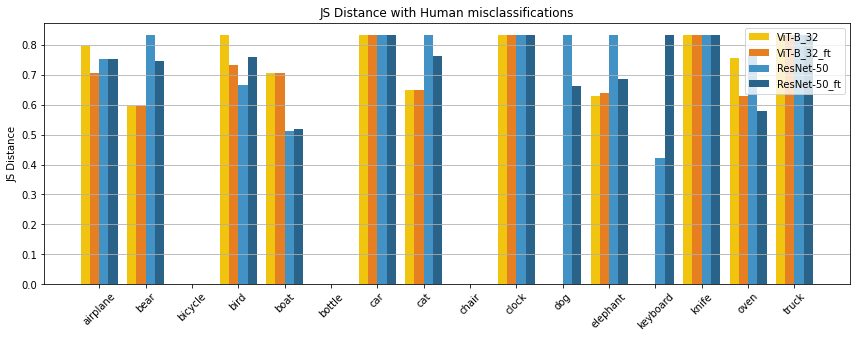

In [33]:
x = np.arange(len(categories_SIN))
width = 0.2

fig, ax = plt.subplots(figsize=[12, 4.8])

count = 0
for model in js_misclassification.keys():
  rects = ax.bar(x - 3*width/2 + width*count, [js_misclassification[model][cat] for cat in categories_SIN], width, label=model, color=colors_bars[count])
  count += 1

ax.set_ylabel('JS Distance')
ax.set_title('JS Distance with Human misclassifications')
ax.set_xticks(x)
plt.xticks(rotation=45)
ax.set_xticklabels(categories_SIN)
ax.legend()
fig.tight_layout()
plt.grid(axis = 'y')
plt.show()

### Plot correlation with Cohen's Kappa

Model: ViT-B_32, 	 JS-Distance: 0.369, 	 Cohen's Kappa: 0.075
Model: ViT-B_32_ft, 	 JS-Distance: 0.347, 	 Cohen's Kappa: 0.086
Model: ResNet-50, 	 JS-Distance: 0.352, 	 Cohen's Kappa: 0.036
Model: ResNet-50_ft, 	 JS-Distance: 0.382, 	 Cohen's Kappa: 0.013


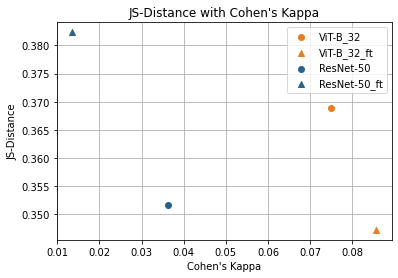

In [34]:
cohens_k = {}

cohens_csv = pd.read_csv(f'../figures_new_ft/texture-shape_{experiment}/texture-shape_{experiment}_kappa.csv')

for model in js_dist_class.keys():
  cohens_k[model] = np.mean(cohens_csv[model])

for model in js_dist_class.keys():
  plt.scatter(cohens_k[model], js_dist_class[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  print(f'Model: {model}, \t JS-Distance: {js_dist_class[model]:0.3f}, \t Cohen\'s Kappa: {cohens_k[model]:0.3f}')

plt.grid()
plt.xlabel('Cohen\'s Kappa')
plt.ylabel('JS-Distance')
plt.title('JS-Distance with Cohen\'s Kappa')
plt.legend()
plt.show()

## Experiment 3: Silhouettes




In [35]:
experiment = 'silhouettes'

### Generate Human confusion matrices

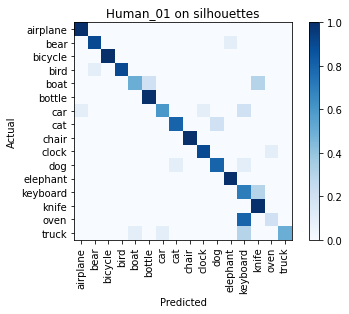

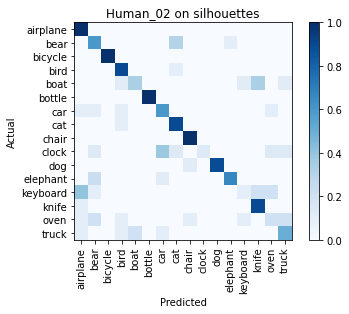

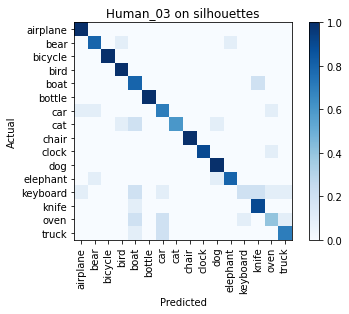

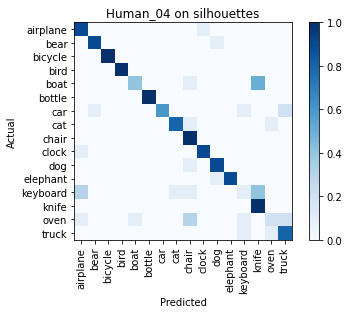

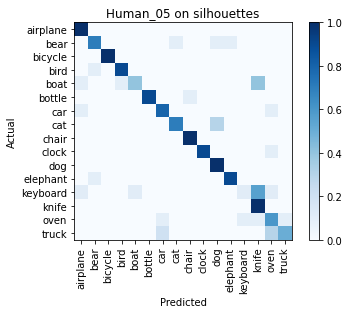

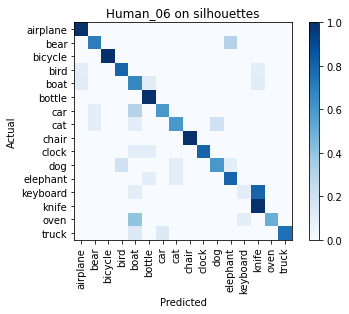

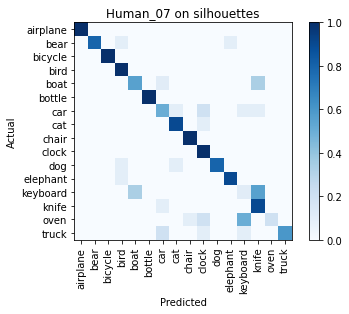

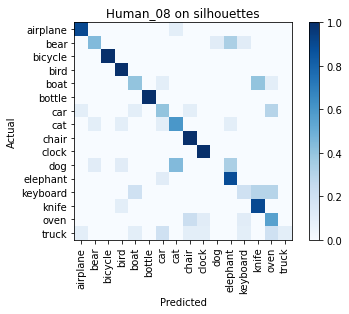

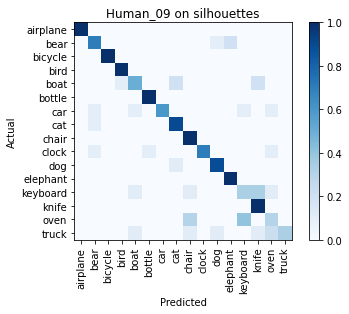

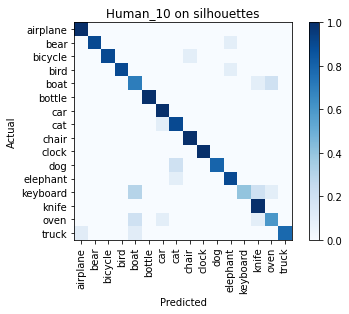

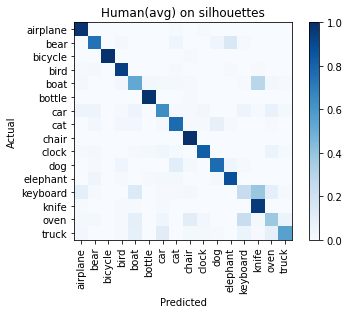

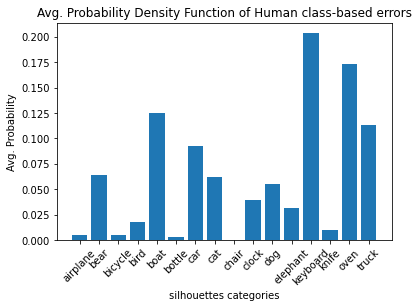

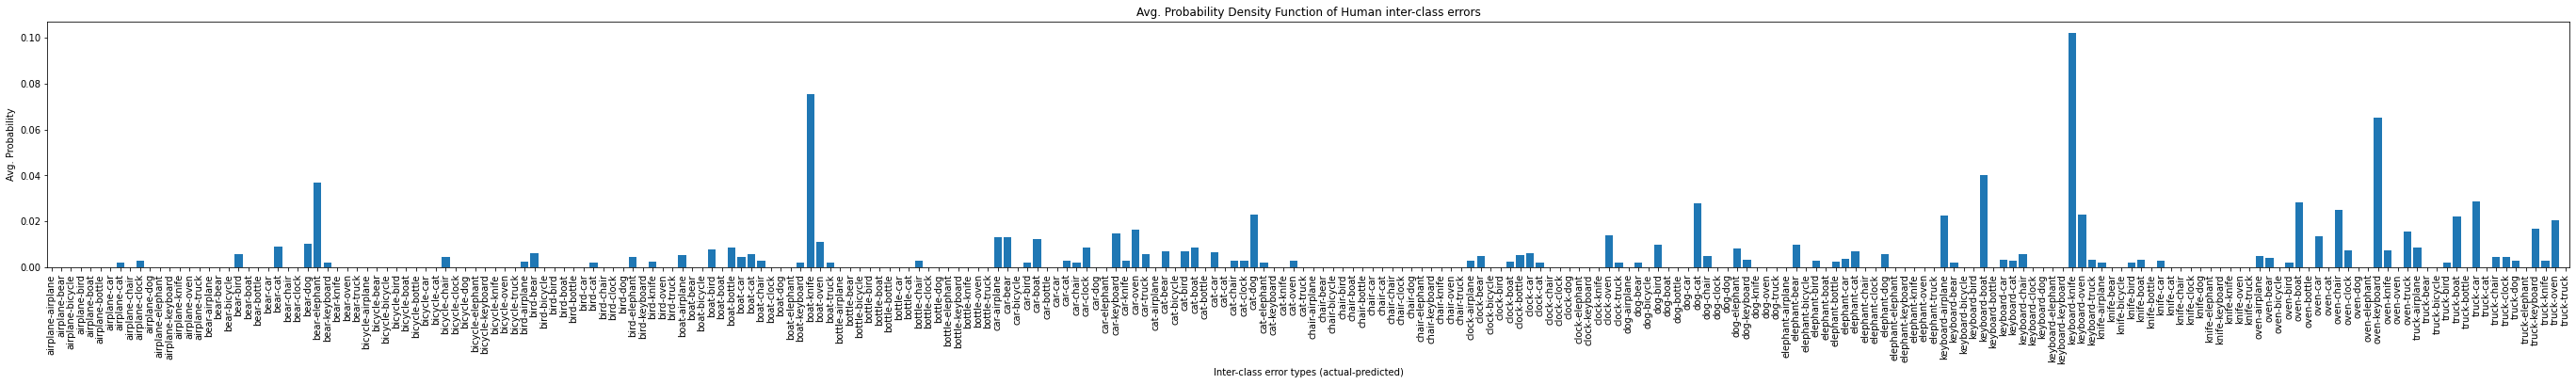

In [36]:
categories_SIN = os.listdir('../../texture-vs-shape/stimuli/style-transfer-preprocessed-512/')
categories_SIN.sort()

class_pdf_list = []
inter_pdf_list = []
misclassification_human = {}
cm_norm_list = []
cm_norm_dict = {}

for i in range(len(categories_SIN)):
  misclassification_human[categories_SIN[i]] = 0

for sub in range(1, 11):
  str_sub = '0'+str(sub) if sub < 10 else str(sub)
  human_csv = pd.read_csv(f'./texture-shape_{experiment}/texture-shape_{experiment}_subject-{str_sub}_session_1.csv')
  pred = human_csv['object_response']
  true = human_csv['category']

  cm = confusion_matrix(true, pred, labels = categories_SIN)
  cm_norm = confusion_matrix(true, pred, labels = categories_SIN, normalize = 'true')

  cm_norm_list.append(cm_norm)

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)

  for i in range(len(categories_SIN)):
    misclassification_human[categories_SIN[i]] += cm_errors[i, [j for j in range(len(categories_SIN)) if j != i]]

  class_pdf_errors = np.sum(cm_errors, axis = 1)
  class_pdf_errors = np.divide(class_pdf_errors, np.sum(class_pdf_errors))
  class_pdf_list.append(class_pdf_errors)
  inter_pdf_errors = np.divide(cm_errors, np.sum(cm_errors)).reshape(-1)
  inter_pdf_list.append(inter_pdf_errors)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues', vmax = 1)
  plt.title(f'Human_{str_sub} on {experiment}')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

class_pdf_avg = np.zeros_like(class_pdf_errors)
inter_pdf_avg = np.zeros_like(inter_pdf_errors)
cm_norm_avg = np.zeros_like(cm_norm)
for i in range(10):
  class_pdf_avg += class_pdf_list[i]
  cm_norm_avg += cm_norm_list[i]
class_pdf_avg = np.divide(class_pdf_avg, 10)
cm_norm_avg = np.divide(cm_norm_avg, 10)

for i in range(10):
  inter_pdf_avg += inter_pdf_list[i]
inter_pdf_avg = np.divide(inter_pdf_avg, 10)

for i in range(len(categories_SIN)):
  misclassification_human[categories_SIN[i]] = np.divide(misclassification_human[categories_SIN[i]], 10)

human_class_pdf = class_pdf_avg
human_inter_pdf = inter_pdf_avg

cm_norm_dict['Human_avg'] = cm_norm_avg

fig, ax = plt.subplots()
plt.imshow(cm_norm_avg, cmap = 'Blues')
plt.title(f'Human(avg) on {experiment}')
plt.colorbar()
ax.set_xticks(np.arange(16))
ax.set_yticks(np.arange(16))
ax.set_xticklabels(categories_SIN, rotation=90)
ax.set_yticklabels(categories_SIN)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

fig = plt.figure()
plt.bar(categories_SIN, class_pdf_avg)
plt.xticks(rotation = 45)
plt.xlabel(f'{experiment} categories')
plt.ylabel('Avg. Probability')
plt.title('Avg. Probability Density Function of Human class-based errors')
plt.show()

fig = plt.figure(figsize=[48, 4.8])
plt.bar([str(c1+'-'+c2) for c1, c2 in itertools.product(categories_SIN, categories_SIN)], inter_pdf_avg)
plt.xticks(rotation = 90)
plt.xlabel('Inter-class error types (actual-predicted)')
plt.ylabel('Avg. Probability')
plt.title('Avg. Probability Density Function of Human inter-class errors')
plt.margins(x=0,tight=True)
plt.show()

### Define distance metric

In [37]:
def kl_distance(p, q):
  non_zero_indices = np.intersect1d(np.where(p!=0)[0], np.where(q!=0)[0])
  return np.sum([p[i] * np.log(p[i] / q[i]) for i in non_zero_indices])

def cross_entropy(p, q):
	return -np.sum(np.where(p != 0, p * np.log(q), 0))
 
def mse(p, q):
  return np.square(np.subtract(p,q)).mean() 

def js_distance(p, q):
  return jensenshannon(p, q)

### Generate ViT confusion matrices

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:1288: RuntimeWarning: invalid value encountered in true_divide
  p = p / np.sum(p, axis=0)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:1289: RuntimeWarning: invalid value encountered in true_divide
  q = q / np.sum(q, axis=0)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


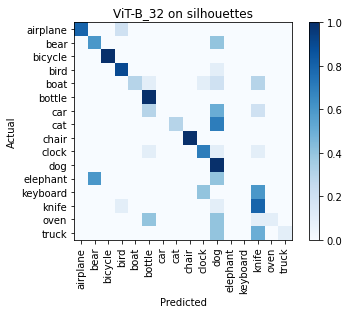

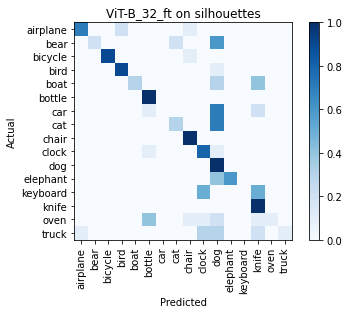

In [38]:
# vit_models = ['B_32', 'B_16', 'L_32', 'L_16', 'B_32_ft']
vit_models = ['B_32', 'B_32_ft']

kl_dist_class = {}
kl_dist_inter = {}

ce_dist_class = {}
ce_dist_inter = {}

js_dist_class = {}
js_dist_inter = {}

mse_misclassification = {}
js_misclassification = {}

acc_exp = {}

for model in vit_models:
  vit_csv = pd.read_csv(f'./texture-shape_{experiment}/texture-shape_{experiment}_ViT-{model}_session-1.csv')
  pred = vit_csv['object_response']
  true = vit_csv['category']

  cm = confusion_matrix(true, pred, labels = categories_SIN)
  cm_norm = confusion_matrix(true, pred, labels = categories_SIN, normalize = 'true')

  if model == 'B_32': cm_norm_dict[f'ViT-{model}'] = cm_norm
  if model == 'B_32_ft': cm_norm_dict[f'ViT-{model}'] = cm_norm

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)

  misclassification_error = {}

  for i in range(len(categories_SIN)):
    misclassification_error[categories_SIN[i]] = cm_errors[i, [j for j in range(len(categories_SIN)) if j != i]]

  mse_misclassification[f'ViT-{model}'] = {category:mse(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}
  js_misclassification[f'ViT-{model}'] = {category:js_distance(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}

  class_pdf_errors = np.sum(cm_errors, axis = 1)
  class_pdf_errors = np.divide(class_pdf_errors, np.sum(class_pdf_errors))
  inter_pdf_errors = np.divide(cm_errors, np.sum(cm_errors)).reshape(-1)

  kl_dist_class[f'ViT-{model}'] = kl_distance(class_pdf_errors, human_class_pdf)
  kl_dist_inter[f'ViT-{model}'] = kl_distance(inter_pdf_errors, human_inter_pdf)

  ce_dist_class[f'ViT-{model}'] = cross_entropy(class_pdf_errors, human_class_pdf)
  ce_dist_inter[f'ViT-{model}'] = cross_entropy(inter_pdf_errors, human_inter_pdf)

  js_dist_class[f'ViT-{model}'] = js_distance(class_pdf_errors, human_class_pdf)
  js_dist_inter[f'ViT-{model}'] = js_distance(inter_pdf_errors, human_inter_pdf)

  acc_exp[f'ViT-{model}'] = accuracy_score(true, pred)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues', vmax = 1)
  plt.title(f'ViT-{model} on {experiment}')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

### Generate ResNet confusion matrices

/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:1288: RuntimeWarning: invalid value encountered in true_divide
  p = p / np.sum(p, axis=0)
/usr/local/lib/python3.6/dist-packages/scipy/spatial/distance.py:1289: RuntimeWarning: invalid value encountered in true_divide
  q = q / np.sum(q, axis=0)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


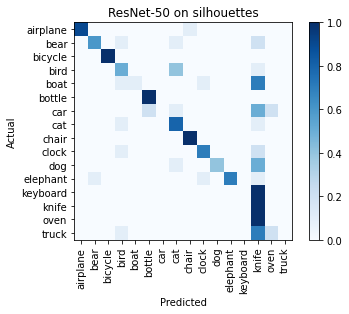

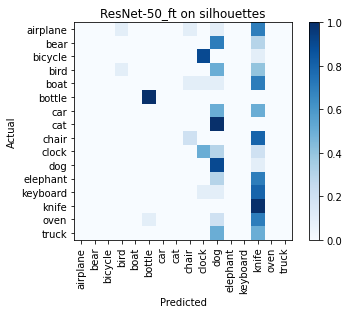

In [39]:
resnet_models = ['resnet50', 'resnet50_ft']

for model in resnet_models:
  resnet_csv = pd.read_csv(f'./texture-shape_{experiment}/texture-shape_{experiment}_{model}_session-1.csv')
  pred = resnet_csv['object_response']
  true = resnet_csv['category']

  cm = confusion_matrix(true, pred, labels = categories_SIN)
  cm_norm = confusion_matrix(true, pred, labels = categories_SIN, normalize = 'true')

  if model == 'resnet50': cm_norm_dict[f'ResNet-50{model[8:]}'] = cm_norm
  if model == 'resnet50_ft': cm_norm_dict[f'ResNet-50{model[8:]}'] = cm_norm

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)

  misclassification_error = {}

  for i in range(len(categories_SIN)):
    misclassification_error[categories_SIN[i]] = cm_errors[i, [j for j in range(len(categories_SIN)) if j != i]]

  mse_misclassification[f'ResNet-50{model[8:]}'] = {category:mse(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}
  js_misclassification[f'ResNet-50{model[8:]}'] = {category:js_distance(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}

  class_pdf_errors = np.sum(cm_errors, axis = 1)
  class_pdf_errors = np.divide(class_pdf_errors, np.sum(class_pdf_errors))
  inter_pdf_errors = np.divide(cm_errors, np.sum(cm_errors)).reshape(-1)

  kl_dist_class[f'ResNet-50{model[8:]}'] = kl_distance(class_pdf_errors, human_class_pdf)
  kl_dist_inter[f'ResNet-50{model[8:]}'] = kl_distance(inter_pdf_errors, human_inter_pdf)

  ce_dist_class[f'ResNet-50{model[8:]}'] = cross_entropy(class_pdf_errors, human_class_pdf)
  ce_dist_inter[f'ResNet-50{model[8:]}'] = cross_entropy(inter_pdf_errors, human_inter_pdf)

  js_dist_class[f'ResNet-50{model[8:]}'] = js_distance(class_pdf_errors, human_class_pdf)
  js_dist_inter[f'ResNet-50{model[8:]}'] = js_distance(inter_pdf_errors, human_inter_pdf)

  acc_exp[f'ResNet-50{model[8:]}'] = accuracy_score(true, pred)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues', vmax = 1)
  plt.title(f'ResNet-50{model[8:]} on {experiment}')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

### Plot relevant confusion matrices together

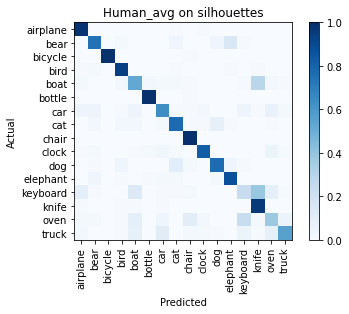

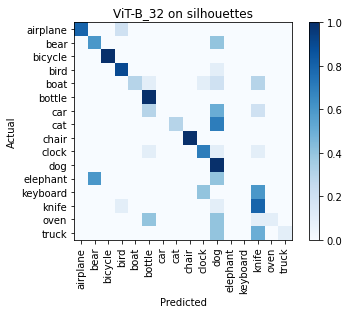

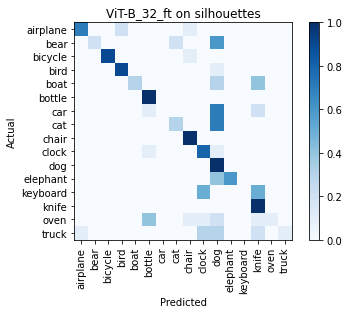

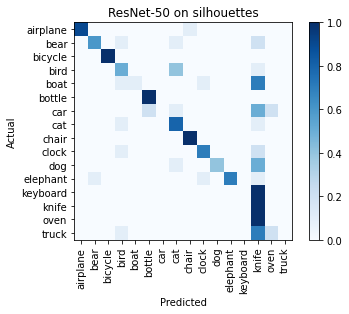

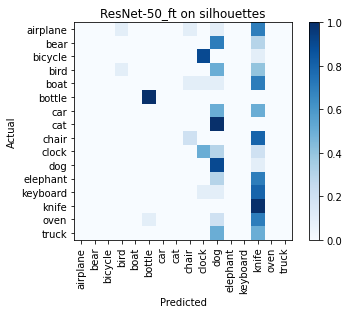

In [40]:
for model in cm_norm_dict.keys():
  
  fig, ax = plt.subplots()
  plt.imshow(cm_norm_dict[model], cmap = 'Blues', vmax = 1)
  plt.title(f'{model} on {experiment}')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

### Plot KL distance for class-wise errors

Model: ViT-B_32, 	 KL-Distance: 0.232
Model: ViT-B_32_ft, 	 KL-Distance: 0.196
Model: ResNet-50, 	 KL-Distance: 0.113
Model: ResNet-50_ft, 	 KL-Distance: 0.466


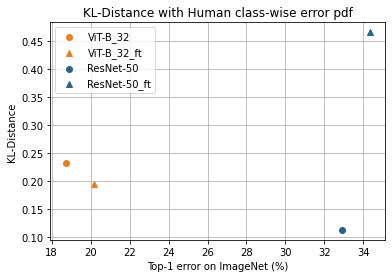

In [41]:
colors_bars = ['#F1C40F', '#E67E22', '#4292C6', '#296389']
colors_scatter = {'ViT-B_32': '#E67E22', 'ViT-B_32_ft': '#E67E22', 'ResNet-50': '#296389', 'ResNet-50_ft': '#296389'}

for model in kl_dist_class.keys():
  if PLOT_IMAGENET_ACC:
    plt.scatter((1-acc_im[model])*100, kl_dist_class[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, kl_dist_class[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  print(f'Model: {model}, \t KL-Distance: {kl_dist_class[model]:0.3f}')

plt.grid()
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)')
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)')
plt.ylabel('KL-Distance')
plt.title('KL-Distance with Human class-wise error pdf')
plt.legend()
plt.show()

### Plot KL distance for inter-class errors

Model: ViT-B_32, 	 KL-Distance: 0.961
Model: ViT-B_32_ft, 	 KL-Distance: 0.825
Model: ResNet-50, 	 KL-Distance: 1.327
Model: ResNet-50_ft, 	 KL-Distance: 0.725


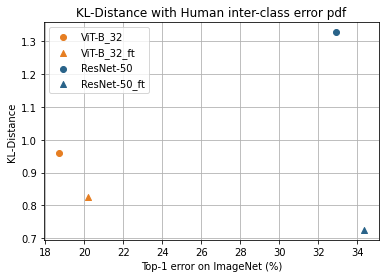

In [42]:
for model in kl_dist_inter.keys():
  if PLOT_IMAGENET_ACC:
    plt.scatter((1-acc_im[model])*100, kl_dist_inter[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, kl_dist_inter[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  print(f'Model: {model}, \t KL-Distance: {kl_dist_inter[model]:0.3f}')

plt.grid()
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)')
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)')
plt.ylabel('KL-Distance')
plt.title('KL-Distance with Human inter-class error pdf')
plt.legend()
plt.show()

### Plot cross-entropy of class-wise errors

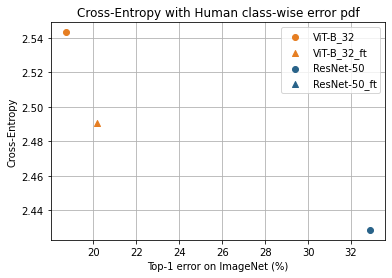

In [43]:
for model in ce_dist_class.keys():
  if PLOT_IMAGENET_ACC:
    plt.scatter((1-acc_im[model])*100, ce_dist_class[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  else:  
    plt.scatter((1-acc_exp[model])*100, ce_dist_class[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')

plt.grid()
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)')
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)')
plt.ylabel('Cross-Entropy')
plt.title('Cross-Entropy with Human class-wise error pdf')
plt.legend()
plt.show()

### Plot JS distance for class-wise errors

Model: ViT-B_32, 	 JS-Distance: 0.237
Model: ViT-B_32_ft, 	 JS-Distance: 0.222
Model: ResNet-50, 	 JS-Distance: 0.166
Model: ResNet-50_ft, 	 JS-Distance: 0.347


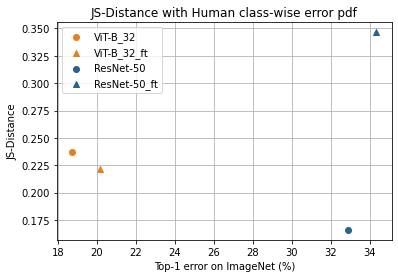

In [44]:
colors_bars = ['#F1C40F', '#E67E22', '#4292C6', '#296389']
colors_scatter = {'ViT-B_32': '#E67E22', 'ViT-B_32_ft': '#E67E22', 'ResNet-50': '#296389', 'ResNet-50_ft': '#296389'}

for model in js_dist_class.keys():
  if PLOT_IMAGENET_ACC:
    plt.scatter((1-acc_im[model])*100, js_dist_class[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, js_dist_class[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  print(f'Model: {model}, \t JS-Distance: {js_dist_class[model]:0.3f}')

plt.grid()
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)')
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)')
plt.ylabel('JS-Distance')
plt.title('JS-Distance with Human class-wise error pdf')
plt.legend()
plt.show()

### Plot JS distance for inter-class errors

Model: ViT-B_32, 	 JS-Distance: 0.697
Model: ViT-B_32_ft, 	 JS-Distance: 0.676
Model: ResNet-50, 	 JS-Distance: 0.658
Model: ResNet-50_ft, 	 JS-Distance: 0.713


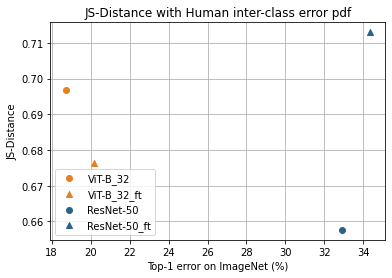

In [45]:
for model in js_dist_inter.keys():
  if PLOT_IMAGENET_ACC:
    plt.scatter((1-acc_im[model])*100, js_dist_inter[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, js_dist_inter[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  print(f'Model: {model}, \t JS-Distance: {js_dist_inter[model]:0.3f}')

plt.grid()
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)')
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)')
plt.ylabel('JS-Distance')
plt.title('JS-Distance with Human inter-class error pdf')
plt.legend()
plt.show()

### Plot MSE distance between misclassifications per class

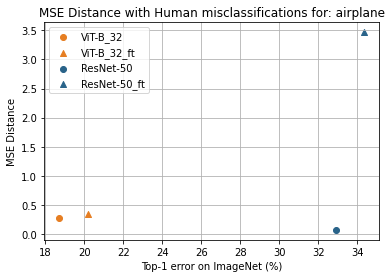

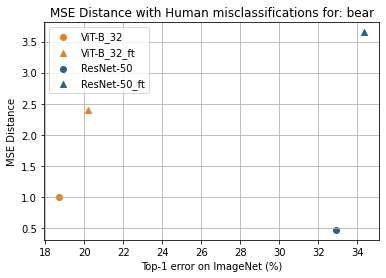

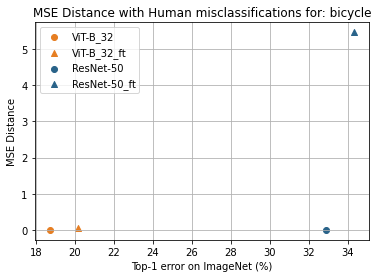

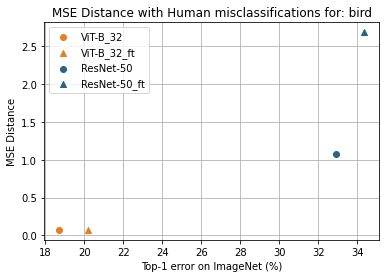

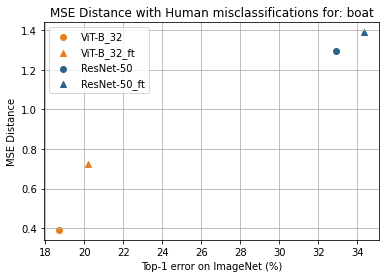

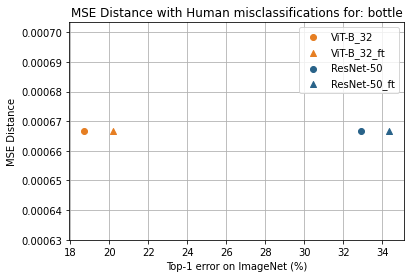

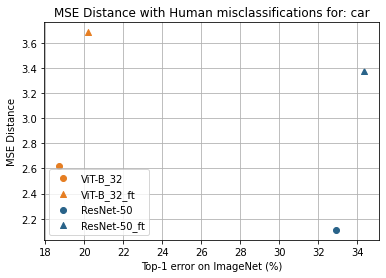

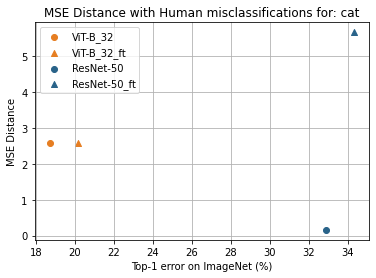

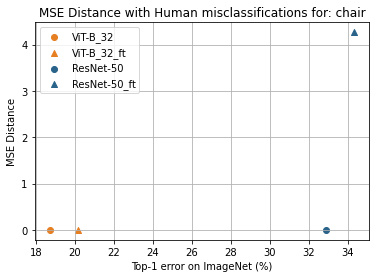

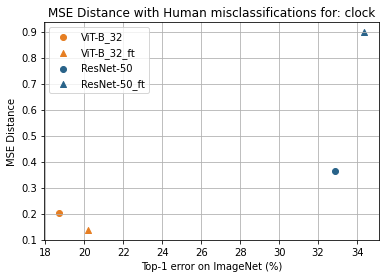

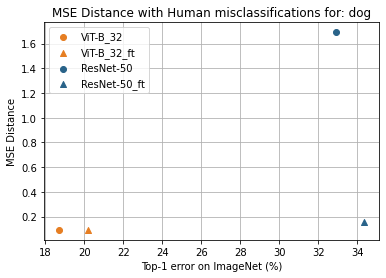

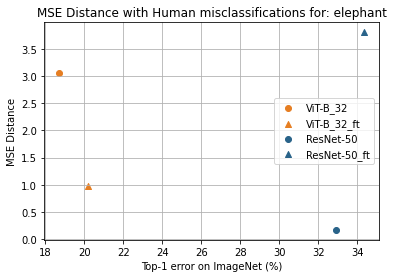

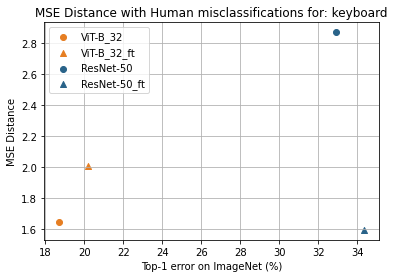

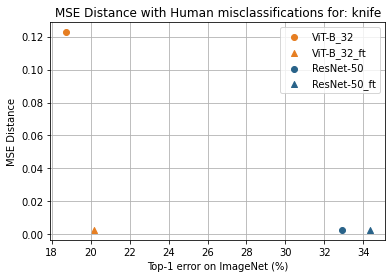

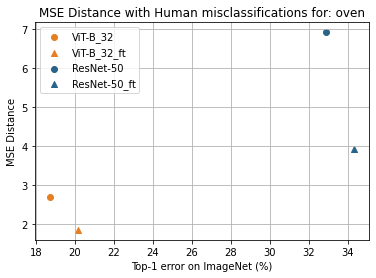

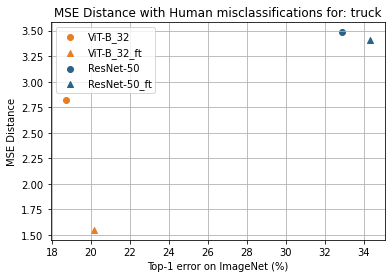

In [46]:
for category in categories_SIN:
  for model in mse_misclassification.keys():
    if PLOT_IMAGENET_ACC:
      plt.scatter((1-acc_im[model])*100, mse_misclassification[model][category], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')  
    else:
      plt.scatter((1-acc_exp[model])*100, mse_misclassification[model][category], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  
  plt.grid()
  if PLOT_IMAGENET_ACC:
    plt.xlabel(f'Top-1 error on ImageNet (%)')
  else:
    plt.xlabel(f'Top-1 error on {experiment} (%)')
  plt.ylabel('MSE Distance')
  plt.title(f'MSE Distance with Human misclassifications for: {category}')
  plt.legend()
  plt.show()

### Plot all MSE distances in one graph

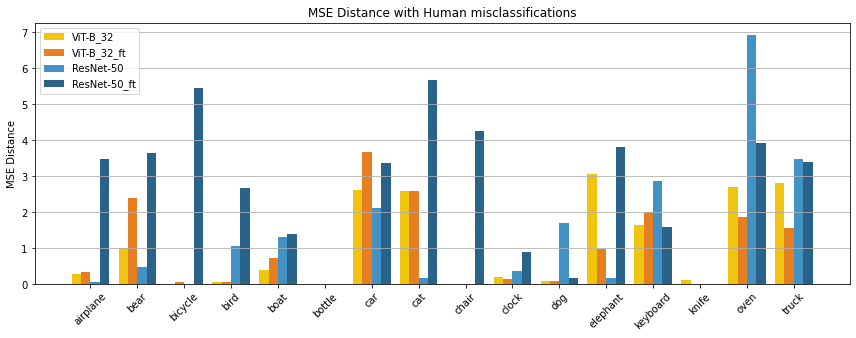

In [47]:
x = np.arange(len(categories_SIN))
width = 0.2

fig, ax = plt.subplots(figsize=[12, 4.8])

count = 0
for model in mse_misclassification.keys():
  rects = ax.bar(x - 3*width/2 + width*count, [mse_misclassification[model][cat] for cat in categories_SIN], width, label=model, color=colors_bars[count])
  count += 1

ax.set_ylabel('MSE Distance')
ax.set_title('MSE Distance with Human misclassifications')
ax.set_xticks(x)
plt.xticks(rotation=45)
ax.set_xticklabels(categories_SIN)
ax.legend()
fig.tight_layout()
plt.grid(axis = 'y')
plt.show()

### Plot JS distance between misclassifications per class

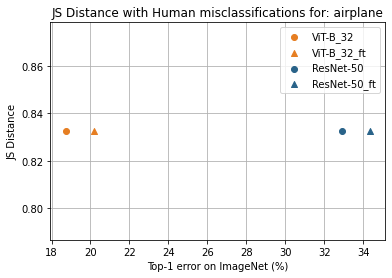

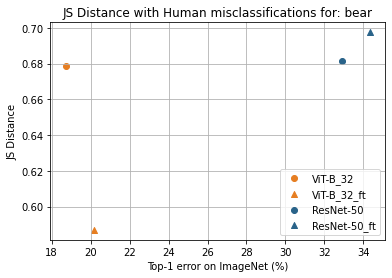

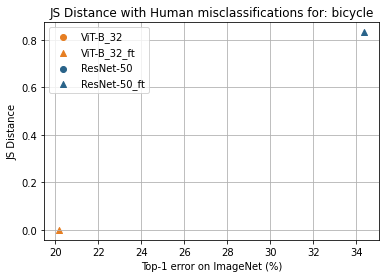

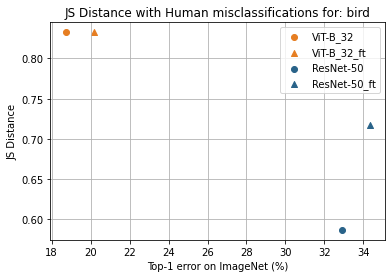

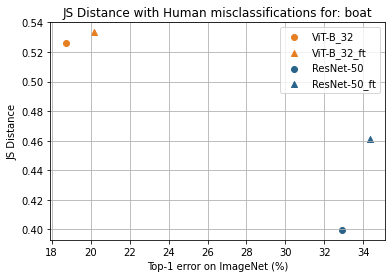

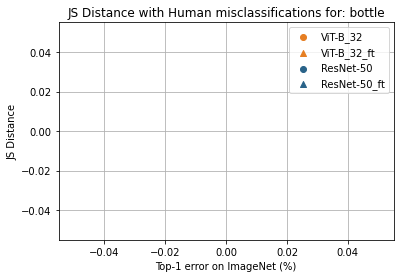

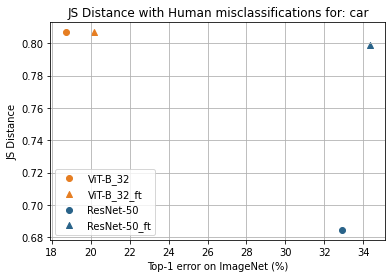

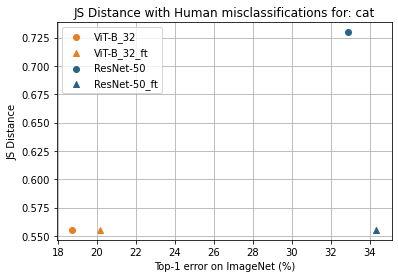

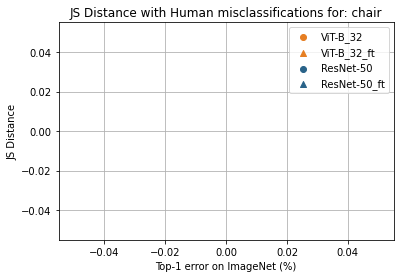

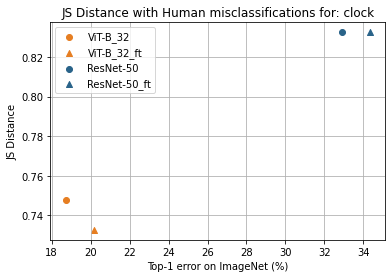

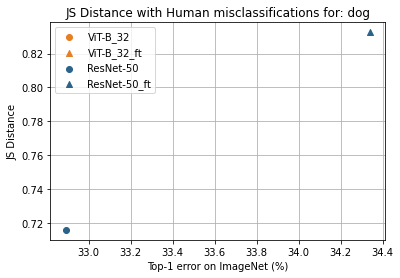

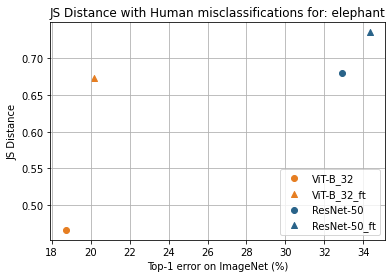

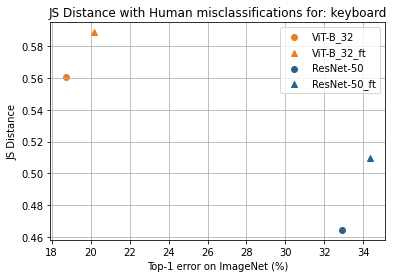

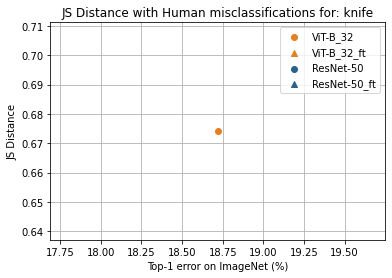

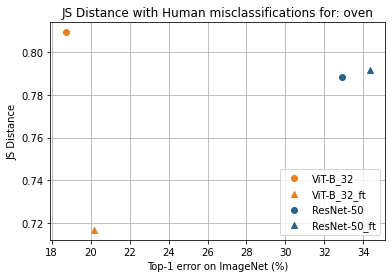

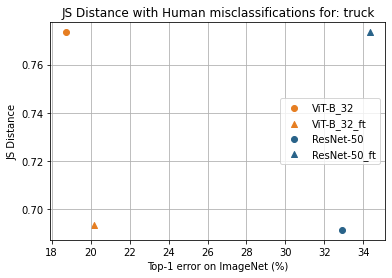

In [48]:
for category in categories_SIN:
  for model in js_misclassification.keys():
    if PLOT_IMAGENET_ACC:
      plt.scatter((1-acc_im[model])*100, js_misclassification[model][category], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')  
    else:
      plt.scatter((1-acc_exp[model])*100, js_misclassification[model][category], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  
  plt.grid()
  if PLOT_IMAGENET_ACC:
    plt.xlabel(f'Top-1 error on ImageNet (%)')
  else:
    plt.xlabel(f'Top-1 error on {experiment} (%)')
  plt.ylabel('JS Distance')
  plt.title(f'JS Distance with Human misclassifications for: {category}')
  plt.legend()
  plt.show()

### Plot all JS distances in one graph

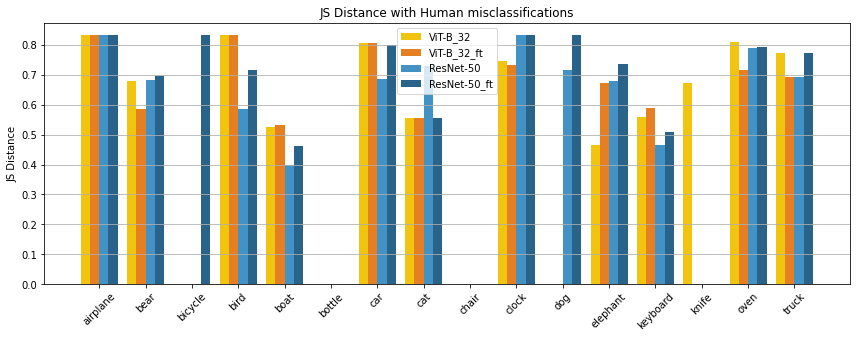

In [49]:
x = np.arange(len(categories_SIN))
width = 0.2

fig, ax = plt.subplots(figsize=[12, 4.8])

count = 0
for model in js_misclassification.keys():
  rects = ax.bar(x - 3*width/2 + width*count, [js_misclassification[model][cat] for cat in categories_SIN], width, label=model, color=colors_bars[count])
  count += 1

ax.set_ylabel('JS Distance')
ax.set_title('JS Distance with Human misclassifications')
ax.set_xticks(x)
plt.xticks(rotation=45)
ax.set_xticklabels(categories_SIN)
ax.legend()
fig.tight_layout()
plt.grid(axis = 'y')
plt.show()

### Plot correlation with Cohen's Kappa

Model: ViT-B_32, 	 JS-Distance: 0.237, 	 Cohen's Kappa: 0.367
Model: ViT-B_32_ft, 	 JS-Distance: 0.222, 	 Cohen's Kappa: 0.378
Model: ResNet-50, 	 JS-Distance: 0.166, 	 Cohen's Kappa: 0.428
Model: ResNet-50_ft, 	 JS-Distance: 0.347, 	 Cohen's Kappa: 0.111


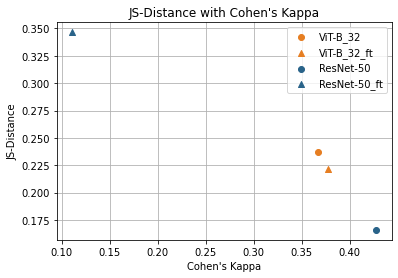

In [50]:
cohens_k = {}

cohens_csv = pd.read_csv(f'../figures_new_ft/texture-shape_{experiment}/texture-shape_{experiment}_kappa.csv')

for model in js_dist_class.keys():
  cohens_k[model] = np.mean(cohens_csv[model])

for model in js_dist_class.keys():
  plt.scatter(cohens_k[model], js_dist_class[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('ft') else 'o')
  print(f'Model: {model}, \t JS-Distance: {js_dist_class[model]:0.3f}, \t Cohen\'s Kappa: {cohens_k[model]:0.3f}')

plt.grid()
plt.xlabel('Cohen\'s Kappa')
plt.ylabel('JS-Distance')
plt.title('JS-Distance with Cohen\'s Kappa')
plt.legend()
plt.show()